In [51]:
import sys
sys.path.append('..')

In [52]:
import os
import pycolmap
from pathlib import Path

import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from hloc.utils.io import list_h5_names, get_matches

from imc2023.utils.eval import eval

In [53]:
DIR = "../image-matching-challenge-2023"
MODE = "train"

datasets = {
    "heritage": ["cyprus", "dioscuri", "wall"],
    "haiper": ["bike", "chairs", "fountain"],
    "urban": ["kyiv-puppet-theater"],
}

out_dir = Path("../outputs")

In [54]:
runs = os.listdir(out_dir)
runs = [r for r in runs if not r.startswith(".")]
runs = sorted(runs)

fil = ["disk", 'loftr', 'ensemble']

runs = [r for r in runs if all(f not in r for f in fil)]

len(runs)

23

In [55]:
metrics = {}

for ds in datasets.keys():
    metrics[ds] = {}
    for scene in datasets[ds]:
        metrics[ds][scene] = {}

        img_dir = f"{DIR}/{MODE}/{ds}/{scene}/images"
        images = sorted(os.listdir(img_dir))
        
        metrics[ds][scene]["images"] = images

## Get models for each run

In [56]:
for ds in datasets.keys():
    for scene in datasets[ds]:
        for r in runs:
            model_dir = out_dir / r / ds / scene / "sparse"
            try:
                model = pycolmap.Reconstruction(model_dir)
            except ValueError:
                print(f"No model found for {ds}/{scene} in {r}")

                metrics[ds][scene][r] = {
                    "reg_images": [],
                    "num_reg_images": 0,
                    "model": None,
                }
                continue

            reg_images = [img.name for img in model.images.values()]
            reg_images = sorted(reg_images)
            metrics[ds][scene][r] = {
                "reg_images": reg_images,
                "num_reg_images": len(reg_images),
                "model": model,
            }

No model found for heritage/cyprus in DISK+LG
No model found for heritage/cyprus in DISK+LG+sift+NN-rot-1600px
No model found for heritage/cyprus in DISK+SP+LG-rot-1600px
No model found for heritage/cyprus in DISK+SP+LG-rot-pixsfm-1600px
No model found for heritage/cyprus in SP+LG+sift+NN-rot
No model found for heritage/cyprus in SP+SG
No model found for heritage/cyprus in SP+SG+cos
No model found for heritage/cyprus in SP+SG-old
No model found for heritage/cyprus in SP+SG-pixsfm
No model found for heritage/cyprus in sift+NN
No model found for heritage/dioscuri in DISK+LG+sift+NN-rot-1600px
No model found for heritage/dioscuri in DISK+SP+LG-rot-1600px
No model found for heritage/dioscuri in DISK+SP+LG-rot-pixsfm-1600px
No model found for heritage/dioscuri in SP+LG+sift+NN-rot
No model found for heritage/wall in DISK+LG+sift+NN-rot-1600px
No model found for heritage/wall in DISK+SP+LG-rot-1600px
No model found for heritage/wall in DISK+SP+LG-rot-pixsfm-1600px
No model found for heritage

## Get eval for each run

In [57]:
create_score = {r: True for r in runs}

for ds in datasets.keys():
    for scene in datasets[ds]:
        pbar = tqdm(runs, desc=f"{ds}/{scene}")
        for r in pbar:
            submission = Path(f"{out_dir}/{r}/submission.csv")
            scores = Path(f"{out_dir}/{r}/scores.json")

            if scores.exists() and not create_score[r]:
                with open(scores, "r") as f:
                    metrics[ds][scene][r]["scores"] = json.load(f)
                continue

            if submission.exists():
                try:
                    metrics[ds][scene][r]["scores"] = eval(
                        submission, DIR, verbose=False, return_dict=True,
                    )
                    create_score[r] = False
                except:
                    metrics[ds][scene][r]["scores"] = None
            else:
                metrics[ds][scene][r]["scores"] = None

            if metrics[ds][scene][r]["scores"] is not None:
                # write scores to file
                with open(f"{out_dir}/{r}/scores.json", "w") as f:
                    json.dump(metrics[ds][scene][r]["scores"], f, indent=4)

                    


urban/kyiv-puppet-theater: 100%|██████████| 23/23 [00:00<00:00, 12420.37it/s]


## Get runtimes for each run

In [58]:
for ds in datasets:
    for scene in datasets[ds]:
        for r in runs:
            timings_path = f"{out_dir}/{r}/{ds}/{scene}/timings.json"

            timings = None
            if os.path.exists(timings_path):
                with open(timings_path, "r") as f:
                    timings = json.load(f)
                
            metrics[ds][scene][r]["timings"] = timings

## Plot num registered images

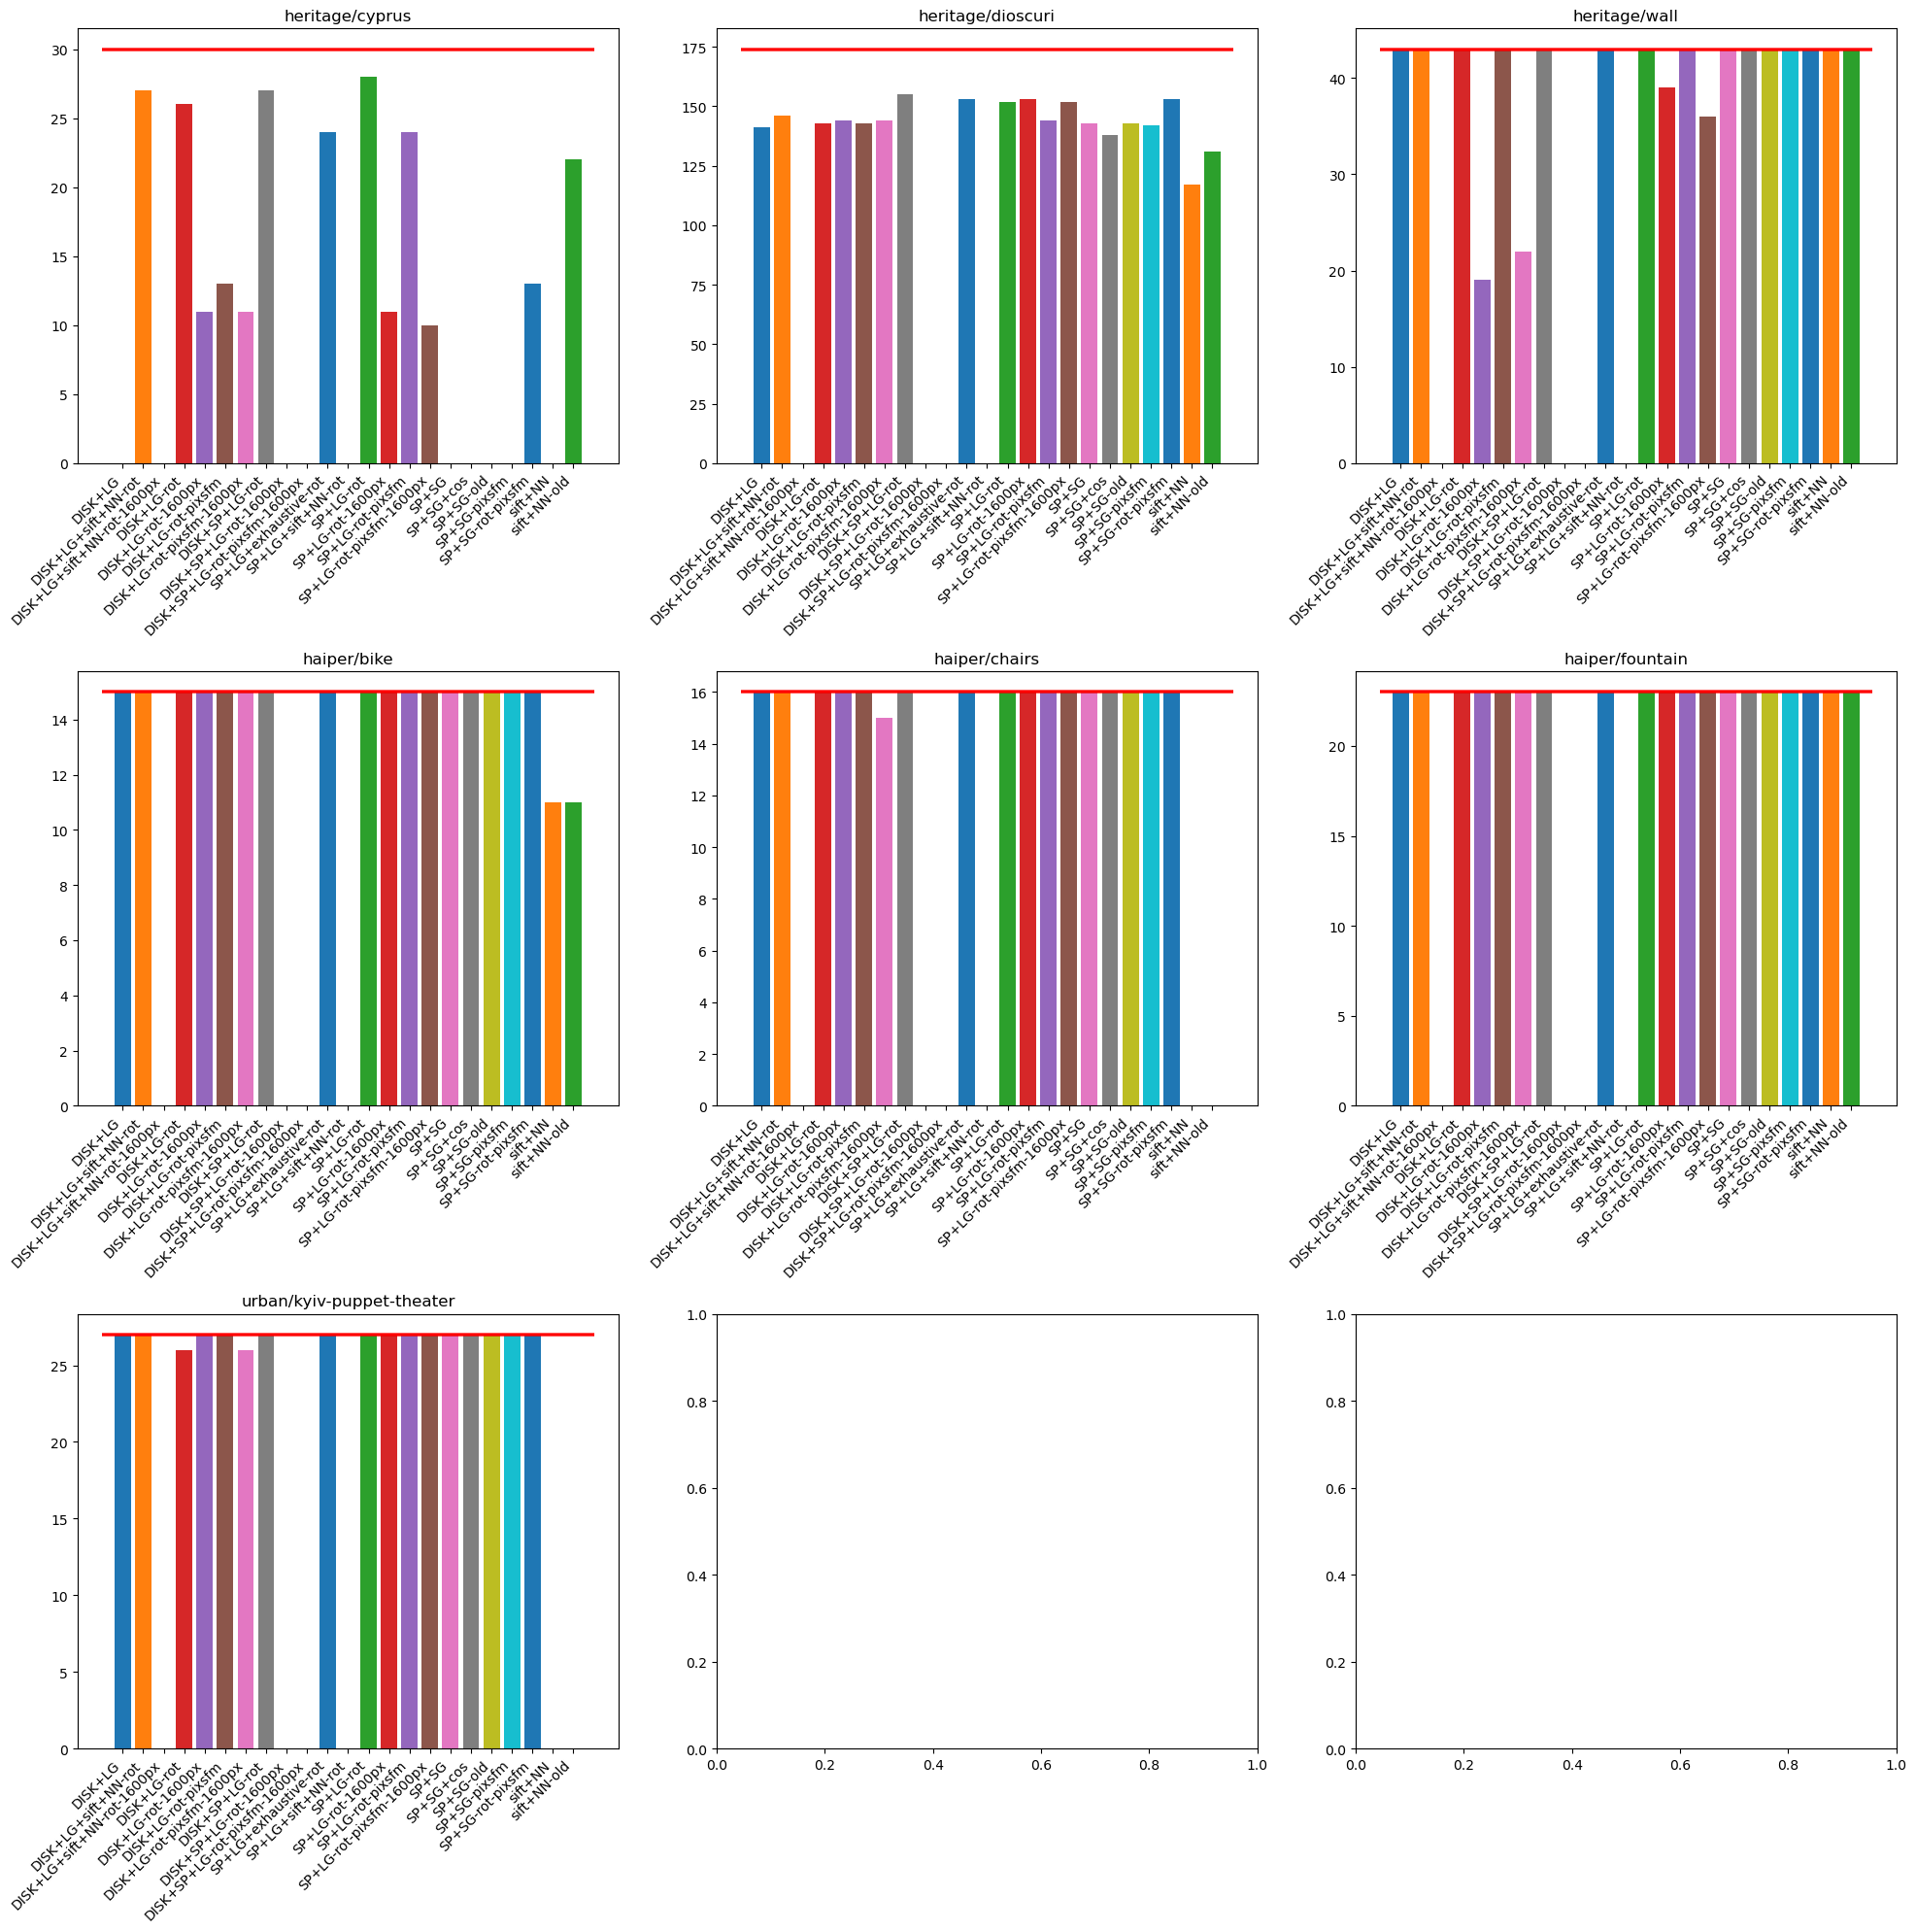

In [59]:
fig, ax = plt.subplots(len(datasets), len(datasets["heritage"]), figsize=(20, 20))

for i, ds in enumerate(datasets.keys()):
    for j, scene in enumerate(datasets[ds]):
        for r in runs:
            if r not in metrics[ds][scene].keys():
                continue

            ax[i, j].bar(
                r,
                metrics[ds][scene][r]["num_reg_images"],
                label=f"{r} ({metrics[ds][scene][r]['num_reg_images']})",
            )

            ax[i, j].hlines(
                len(metrics[ds][scene]["images"]),
                -1,
                len(runs),
                label=f"GT ({len(metrics[ds][scene]['images'])})",
                colors="r",
            )
            
            ax[i, j].set_title(f"{ds}/{scene}")

            # rotate x-axis labels and align them to the right
            for tick in ax[i, j].get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha("right")

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

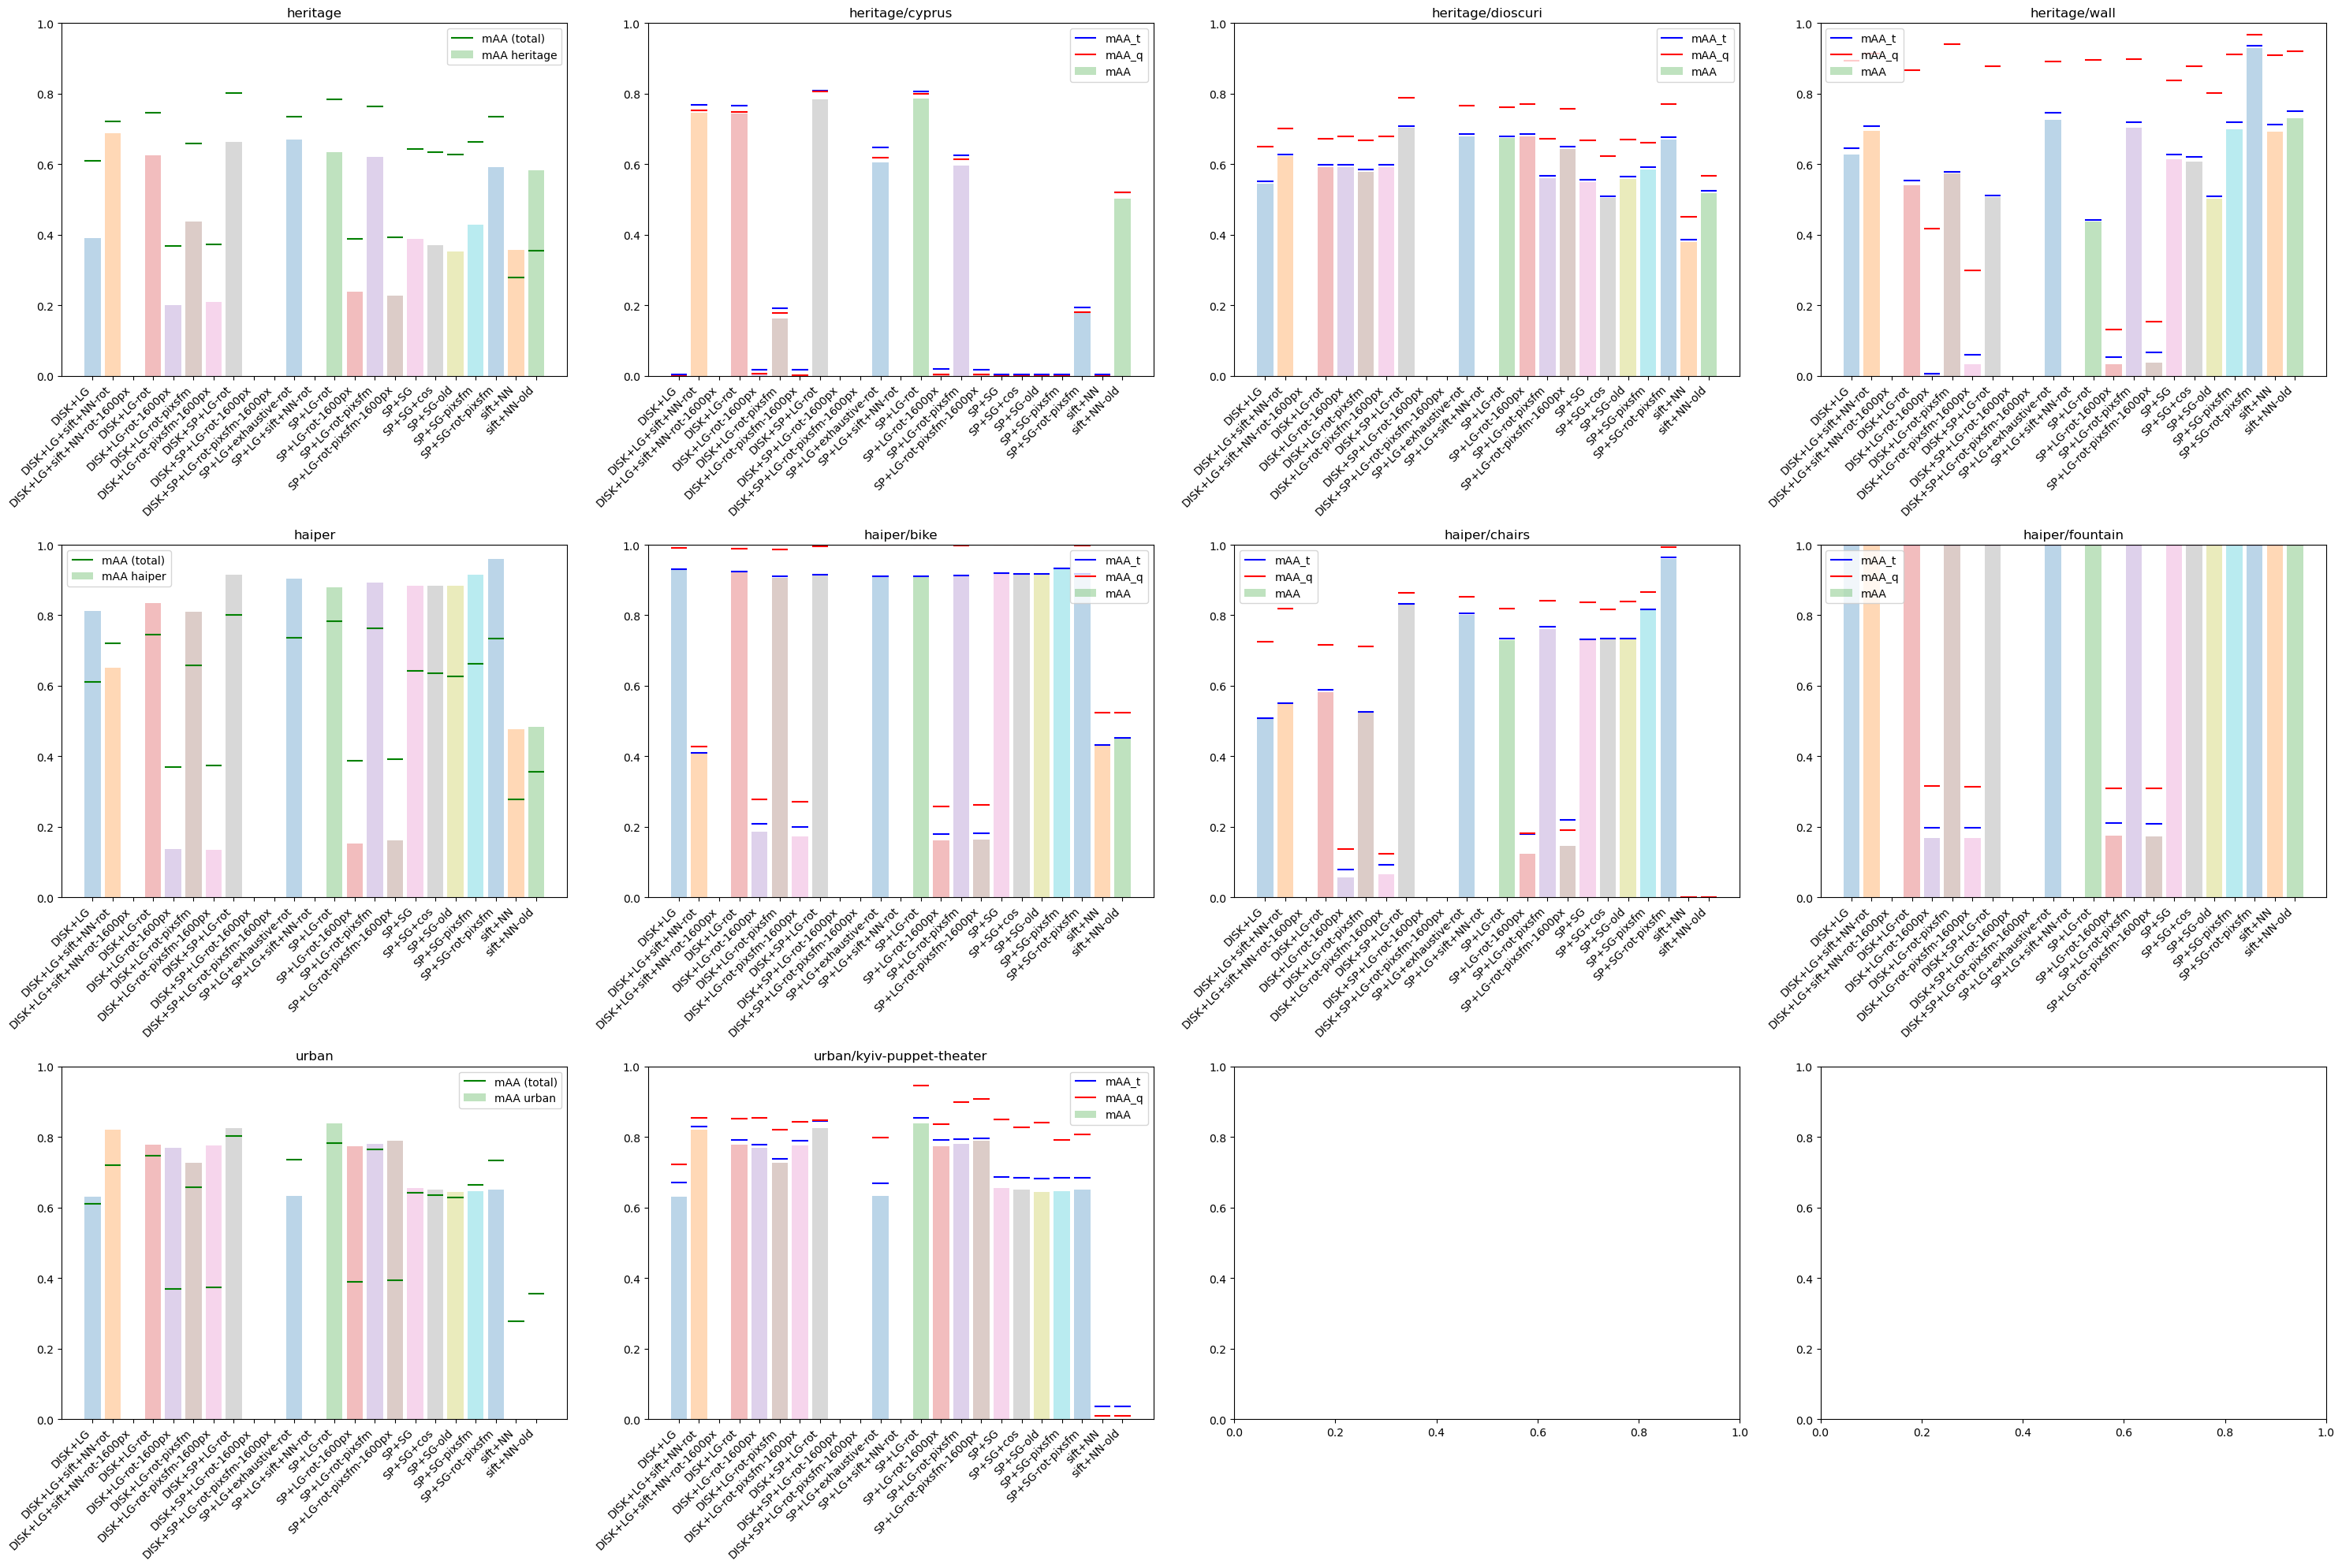

In [60]:
fig, ax = plt.subplots(len(datasets), len(datasets["heritage"])+1, figsize=(30, 20))

for i, ds in enumerate(datasets.keys()):
    for j, scene in enumerate(datasets[ds]):
        for r in runs:
            if r not in metrics[ds][scene].keys():
                continue

            if metrics[ds][scene][r]["scores"] is None:
                ax[i, j+1].bar(
                    r,
                    0,
                )
                continue
            
            ax[i, j+1].bar(
                r,
                metrics[ds][scene][r]["scores"][ds][scene]["mAA"],
                alpha=0.3,
                # color="b",
                label="mAA" if r == runs[-1] else "",
            )

            ax[i, j+1].hlines(
                metrics[ds][scene][r]["scores"][ds][scene]["mAA_t"],
                runs.index(r) - 0.4,
                runs.index(r) + 0.4,
                color="b",
                label="mAA_t" if r == runs[-1] else "",
            )

            ax[i, j+1].hlines(
                metrics[ds][scene][r]["scores"][ds][scene]["mAA_q"],
                runs.index(r) - 0.4,
                runs.index(r) + 0.4,
                color="r",
                label="mAA_q" if r == runs[-1] else "",
            )
            
            ax[i, j+1].set_title(f"{ds}/{scene}")

            # rotate x-axis labels and align them to the right
            for tick in ax[i, j+1].get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha("right")


        ax[i, j+1].legend()
        ax[i, j+1].set_ylim(0, 1)

for i, ds in enumerate(datasets.keys()):
    scene = datasets[ds][0]
    for r in runs:
        if metrics[ds][scene][r]["scores"] is None:
            ax[i, 0].bar(
                r,
                0,
            )
            continue

        ax[i, 0].bar(
            r,
            metrics[ds][scene][r]["scores"][ds]["mAA"],
            alpha=0.3,
            # color="b",
            label=f"mAA {ds}" if r == runs[-1] else "",
        )

        ax[i, 0].hlines(
            metrics[ds][scene][r]["scores"]["mAA"],
            runs.index(r) - 0.4,
            runs.index(r) + 0.4,
            color="g",
            label="mAA (total)" if r == runs[-1] else "",
        )

        ax[i, 0].set_title(f"{ds}")

        ax[i, 0].set_ylim(0, 1)

        # rotate x-axis labels and align them to the right
        for tick in ax[i, 0].get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")

        ax[i, 0].legend()
            
plt.tight_layout()
plt.show()

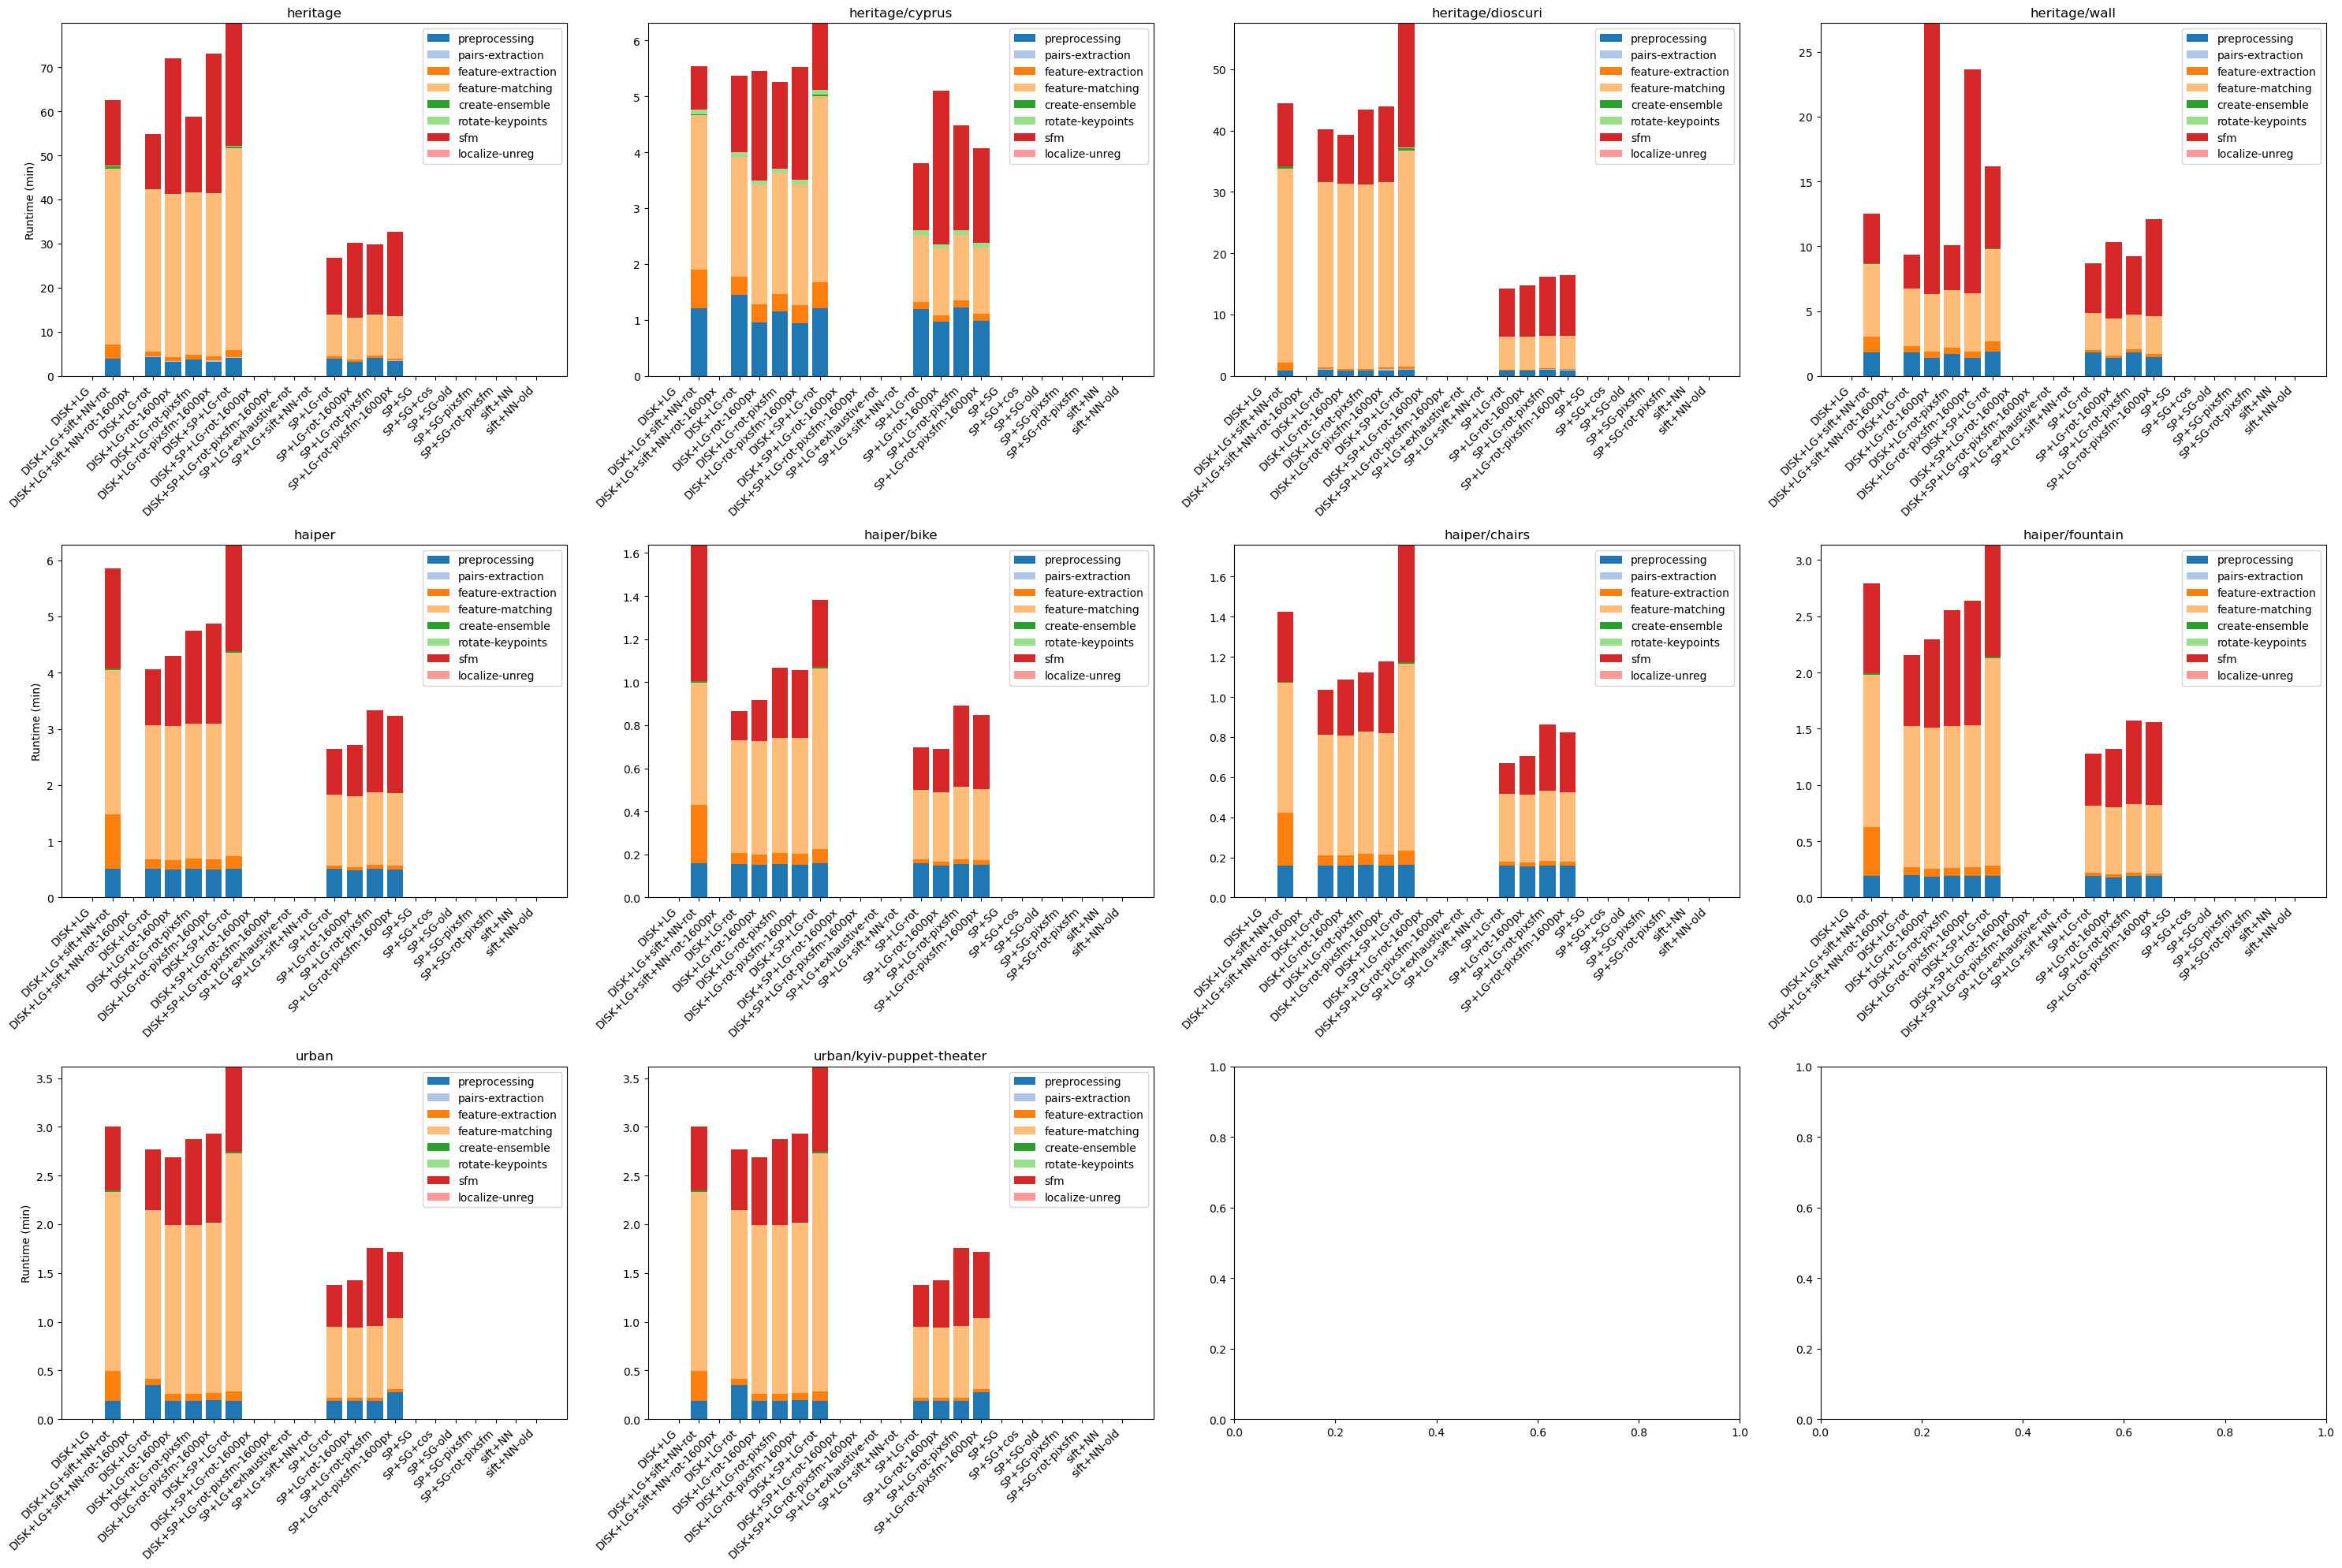

In [61]:
fig, ax = plt.subplots(len(datasets), len(datasets["heritage"])+1, figsize=(30, 20))

cmap = plt.get_cmap("tab20")


for i, ds in enumerate(datasets.keys()):
    for j, scene in enumerate(datasets[ds]):
        take_for_legend = True
        for r in runs:
            if r not in metrics[ds][scene].keys():
                continue

            if metrics[ds][scene][r]["timings"] is None:
                ax[i, j+1].bar(
                    r,
                    0,
                )
                continue

            # stacked bar plot
            times = list(metrics[ds][scene][r]["timings"].items())
            total = sum(t[1] for t in times)

            cumsum = 0


            for idx, (k, v) in enumerate(times):
                ax[i, j+1].bar(
                    r,
                    v / 60,
                    bottom=cumsum,
                    label=k if take_for_legend else "",
                    color=cmap(idx),
                )
                cumsum += v / 60

            take_for_legend = False

            ax[i, j+1].set_title(f"{ds}/{scene}")

            # rotate x-axis labels and align them to the right
            for tick in ax[i, j+1].get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha("right")

            ax[i, j+1].legend()



total_per_ds = {}
for ds in datasets.keys():
    total_per_ds[ds] = {}
    for r in runs:
        total_per_ds[ds][r] = {}
        for scene in datasets[ds]:
            if metrics[ds][scene][r]["timings"] is None:
                continue
            
            for k, v in metrics[ds][scene][r]["timings"].items():
                if k not in total_per_ds[ds][r].keys():
                    total_per_ds[ds][r][k] = 0
                    
                total_per_ds[ds][r][k] += v

for i, ds in enumerate(datasets.keys()):
    take_for_legend = True
    for r in runs:

        if total_per_ds[ds][r] == {}:
            ax[i, 0].bar(
                r,
                0,
            )
            continue
        
        cumsum = 0
        for idx, (k, v) in enumerate(total_per_ds[ds][r].items()):
            ax[i, 0].bar(
                r,
                v / 60,
                bottom=cumsum,
                label=k if take_for_legend else "",
                color=cmap(idx),
            )
            cumsum += v / 60

        take_for_legend = False

        ax[i, 0].set_title(f"{ds}")

        # rotate x-axis labels and align them to the right
        for tick in ax[i, 0].get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")

        ax[i, 0].set_ylabel("Runtime (min)")

        ax[i, 0].legend()

plt.tight_layout()
plt.show()

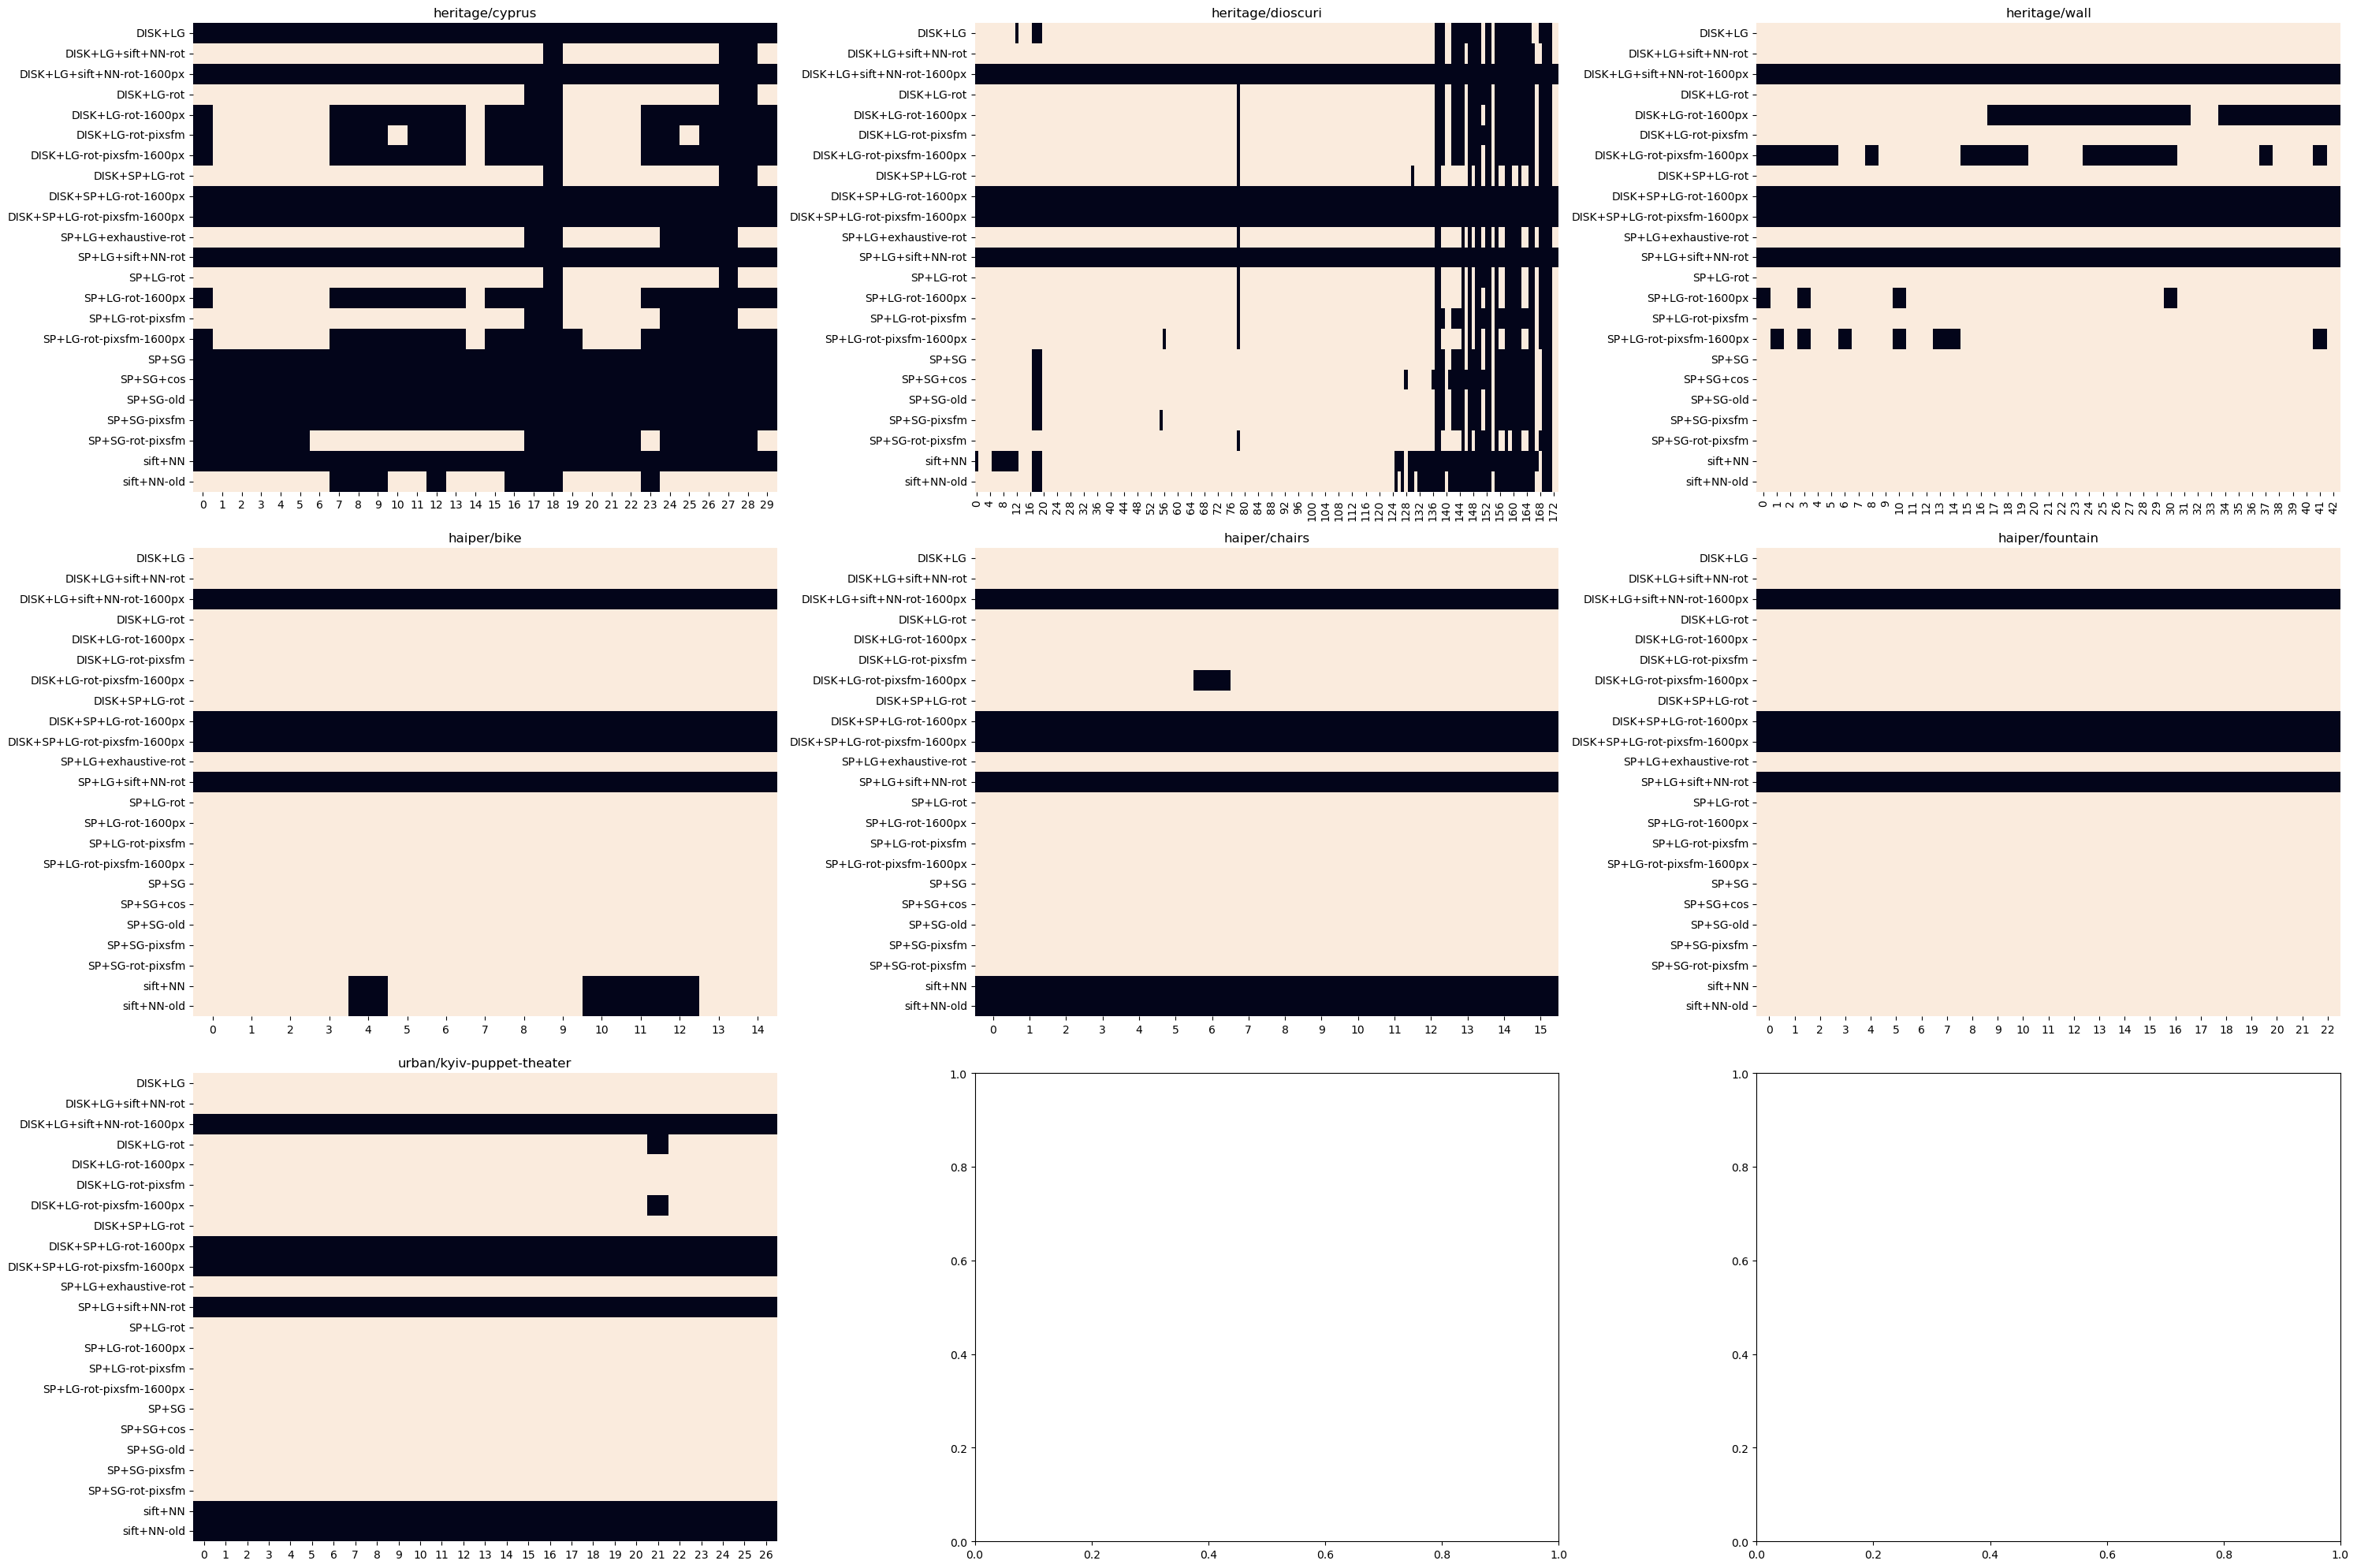

In [49]:
fig, ax = plt.subplots(len(datasets), len(datasets["heritage"]), figsize=(30, 20))

for i, ds in enumerate(datasets.keys()):
    for j, scene in enumerate(datasets[ds]):
        bool_img_run = np.zeros((len(runs), len(metrics[ds][scene]["images"])))
        
        for r_idx, r in enumerate(runs):
            if r not in metrics[ds][scene].keys():
                continue

            for img in metrics[ds][scene][r]["reg_images"]:
                img_idx = metrics[ds][scene]["images"].index(img)
                bool_img_run[r_idx, img_idx] = 1

        sns.heatmap(
            bool_img_run,
            ax=ax[i, j],
            cbar=False,
            vmin=0,
            vmax=1,
            yticklabels=runs,
        )
        ax[i, j].set_title(f"{ds}/{scene}")

# add more space between plots
plt.tight_layout()

heritage/cyprus: 100%|██████████| 23/23 [00:10<00:00,  2.14it/s]


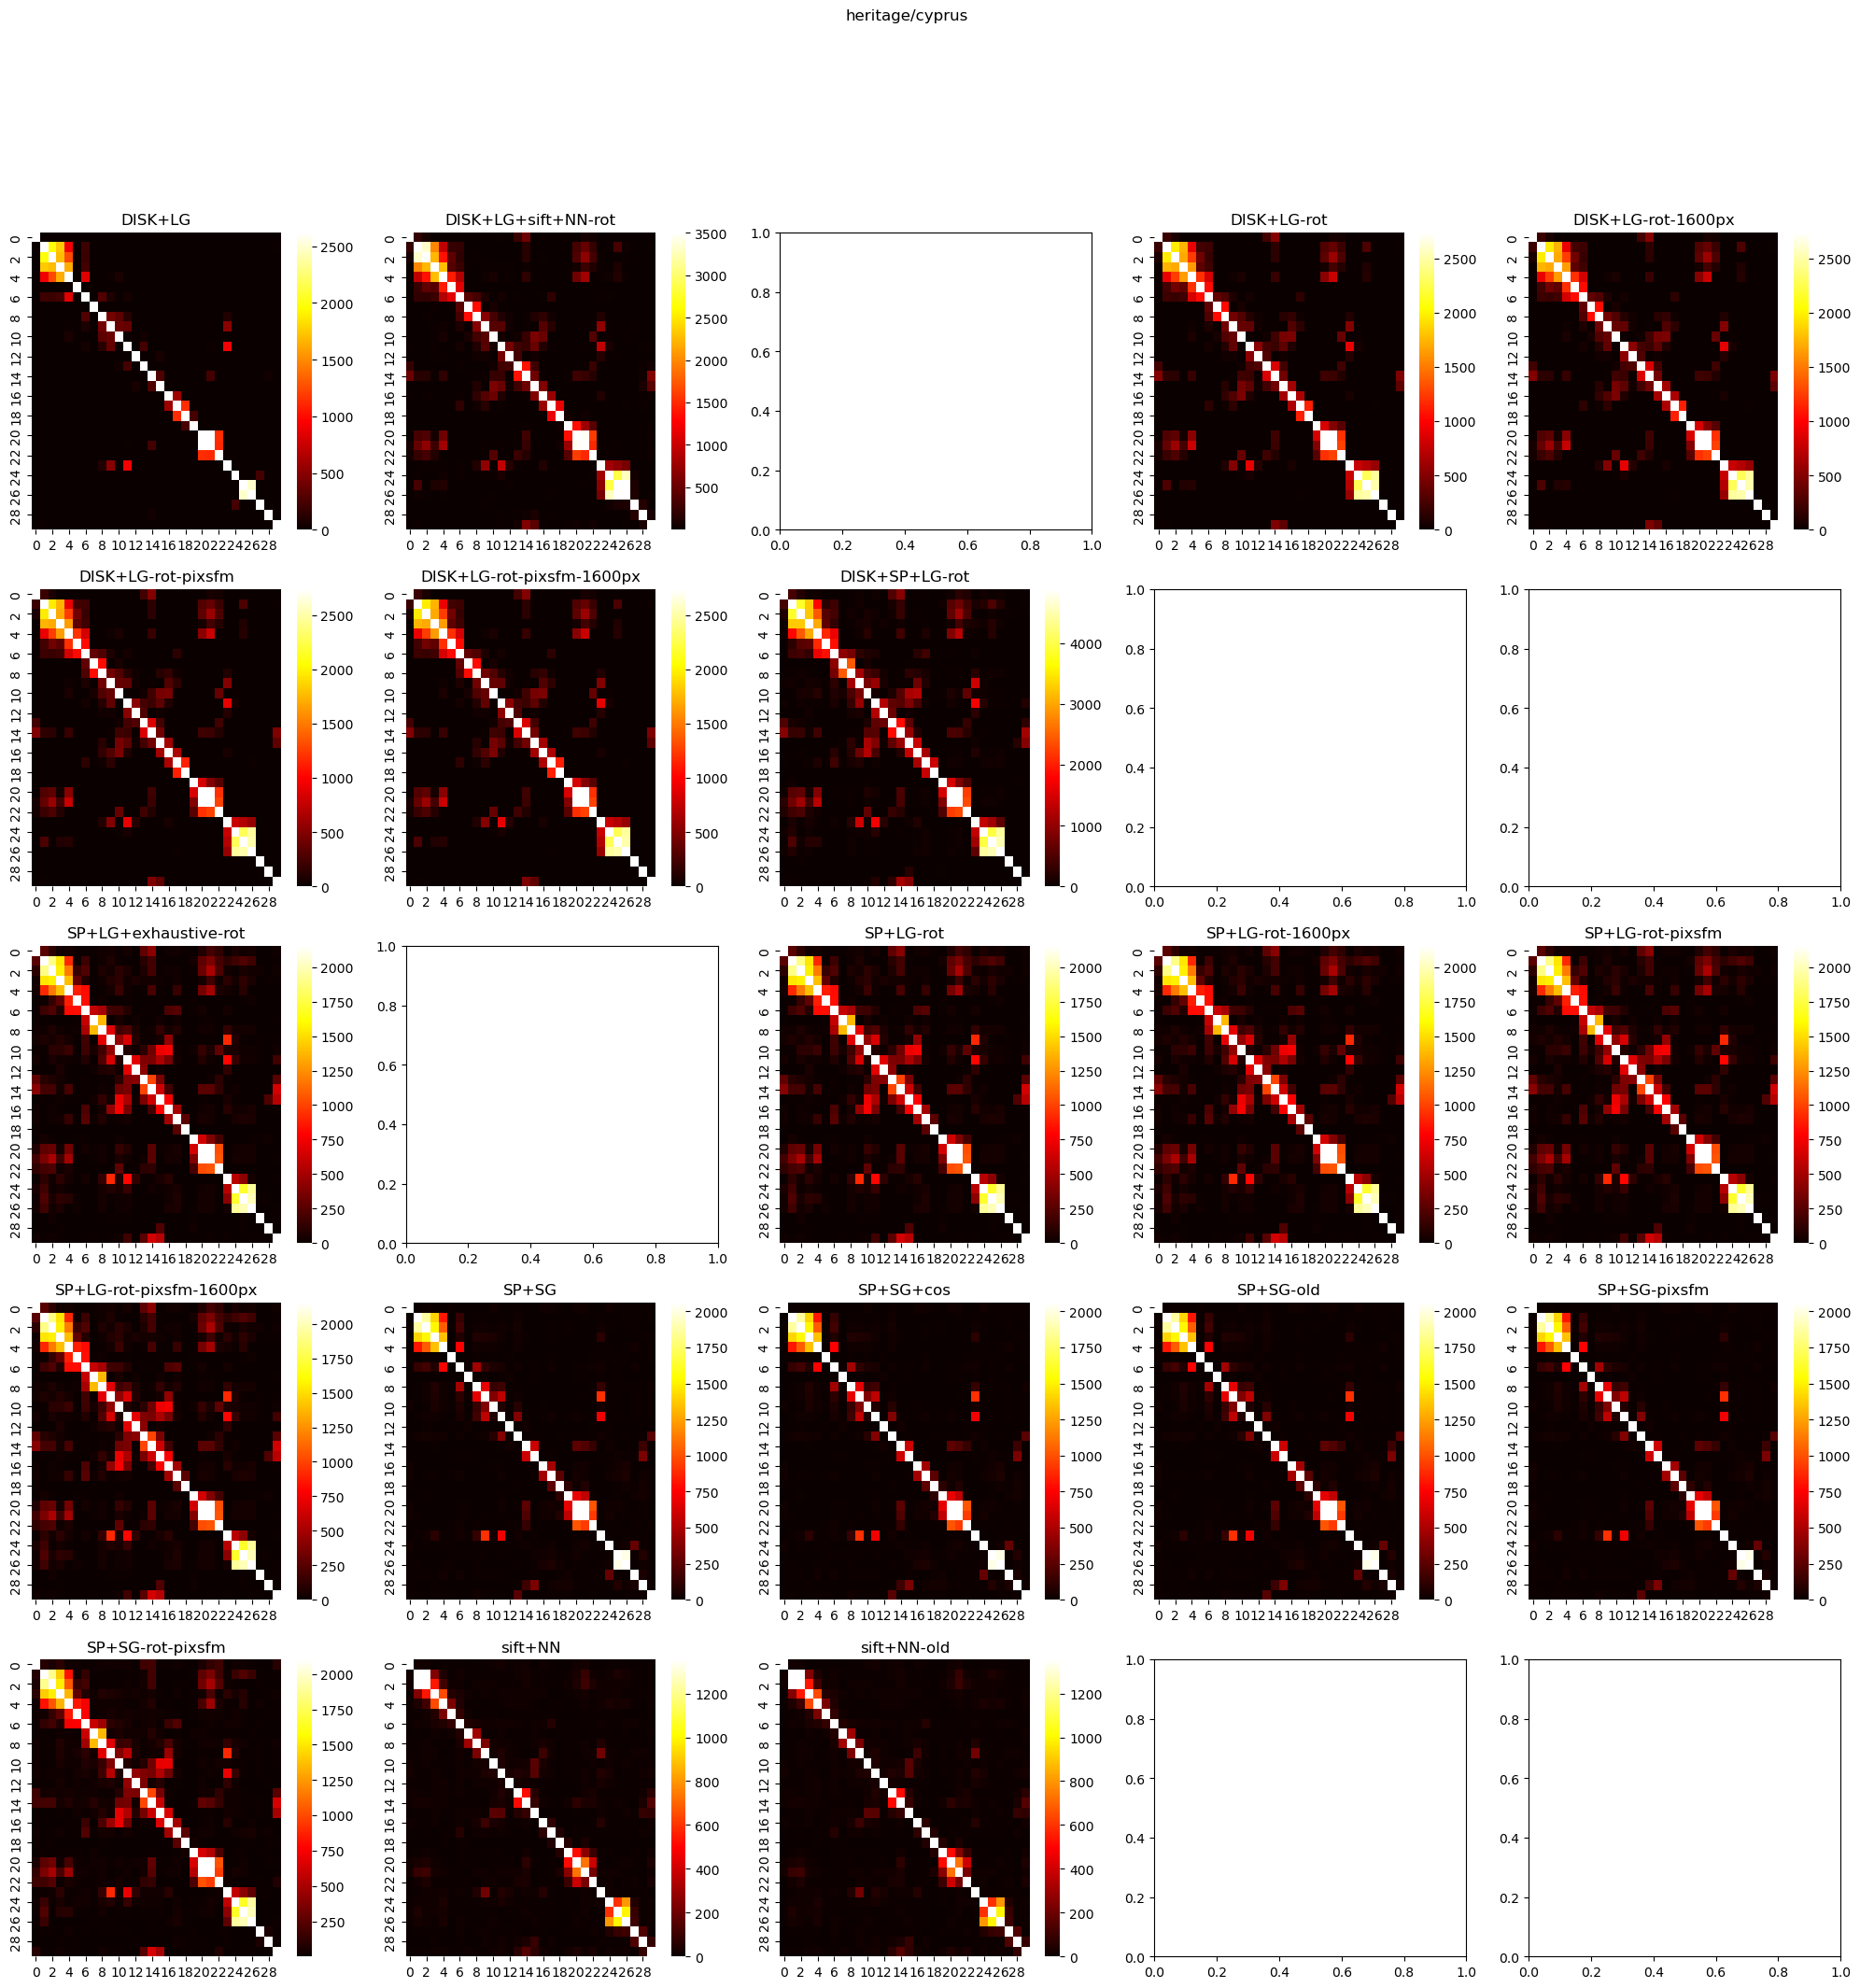

heritage/dioscuri: 100%|██████████| 23/23 [01:14<00:00,  3.24s/it]


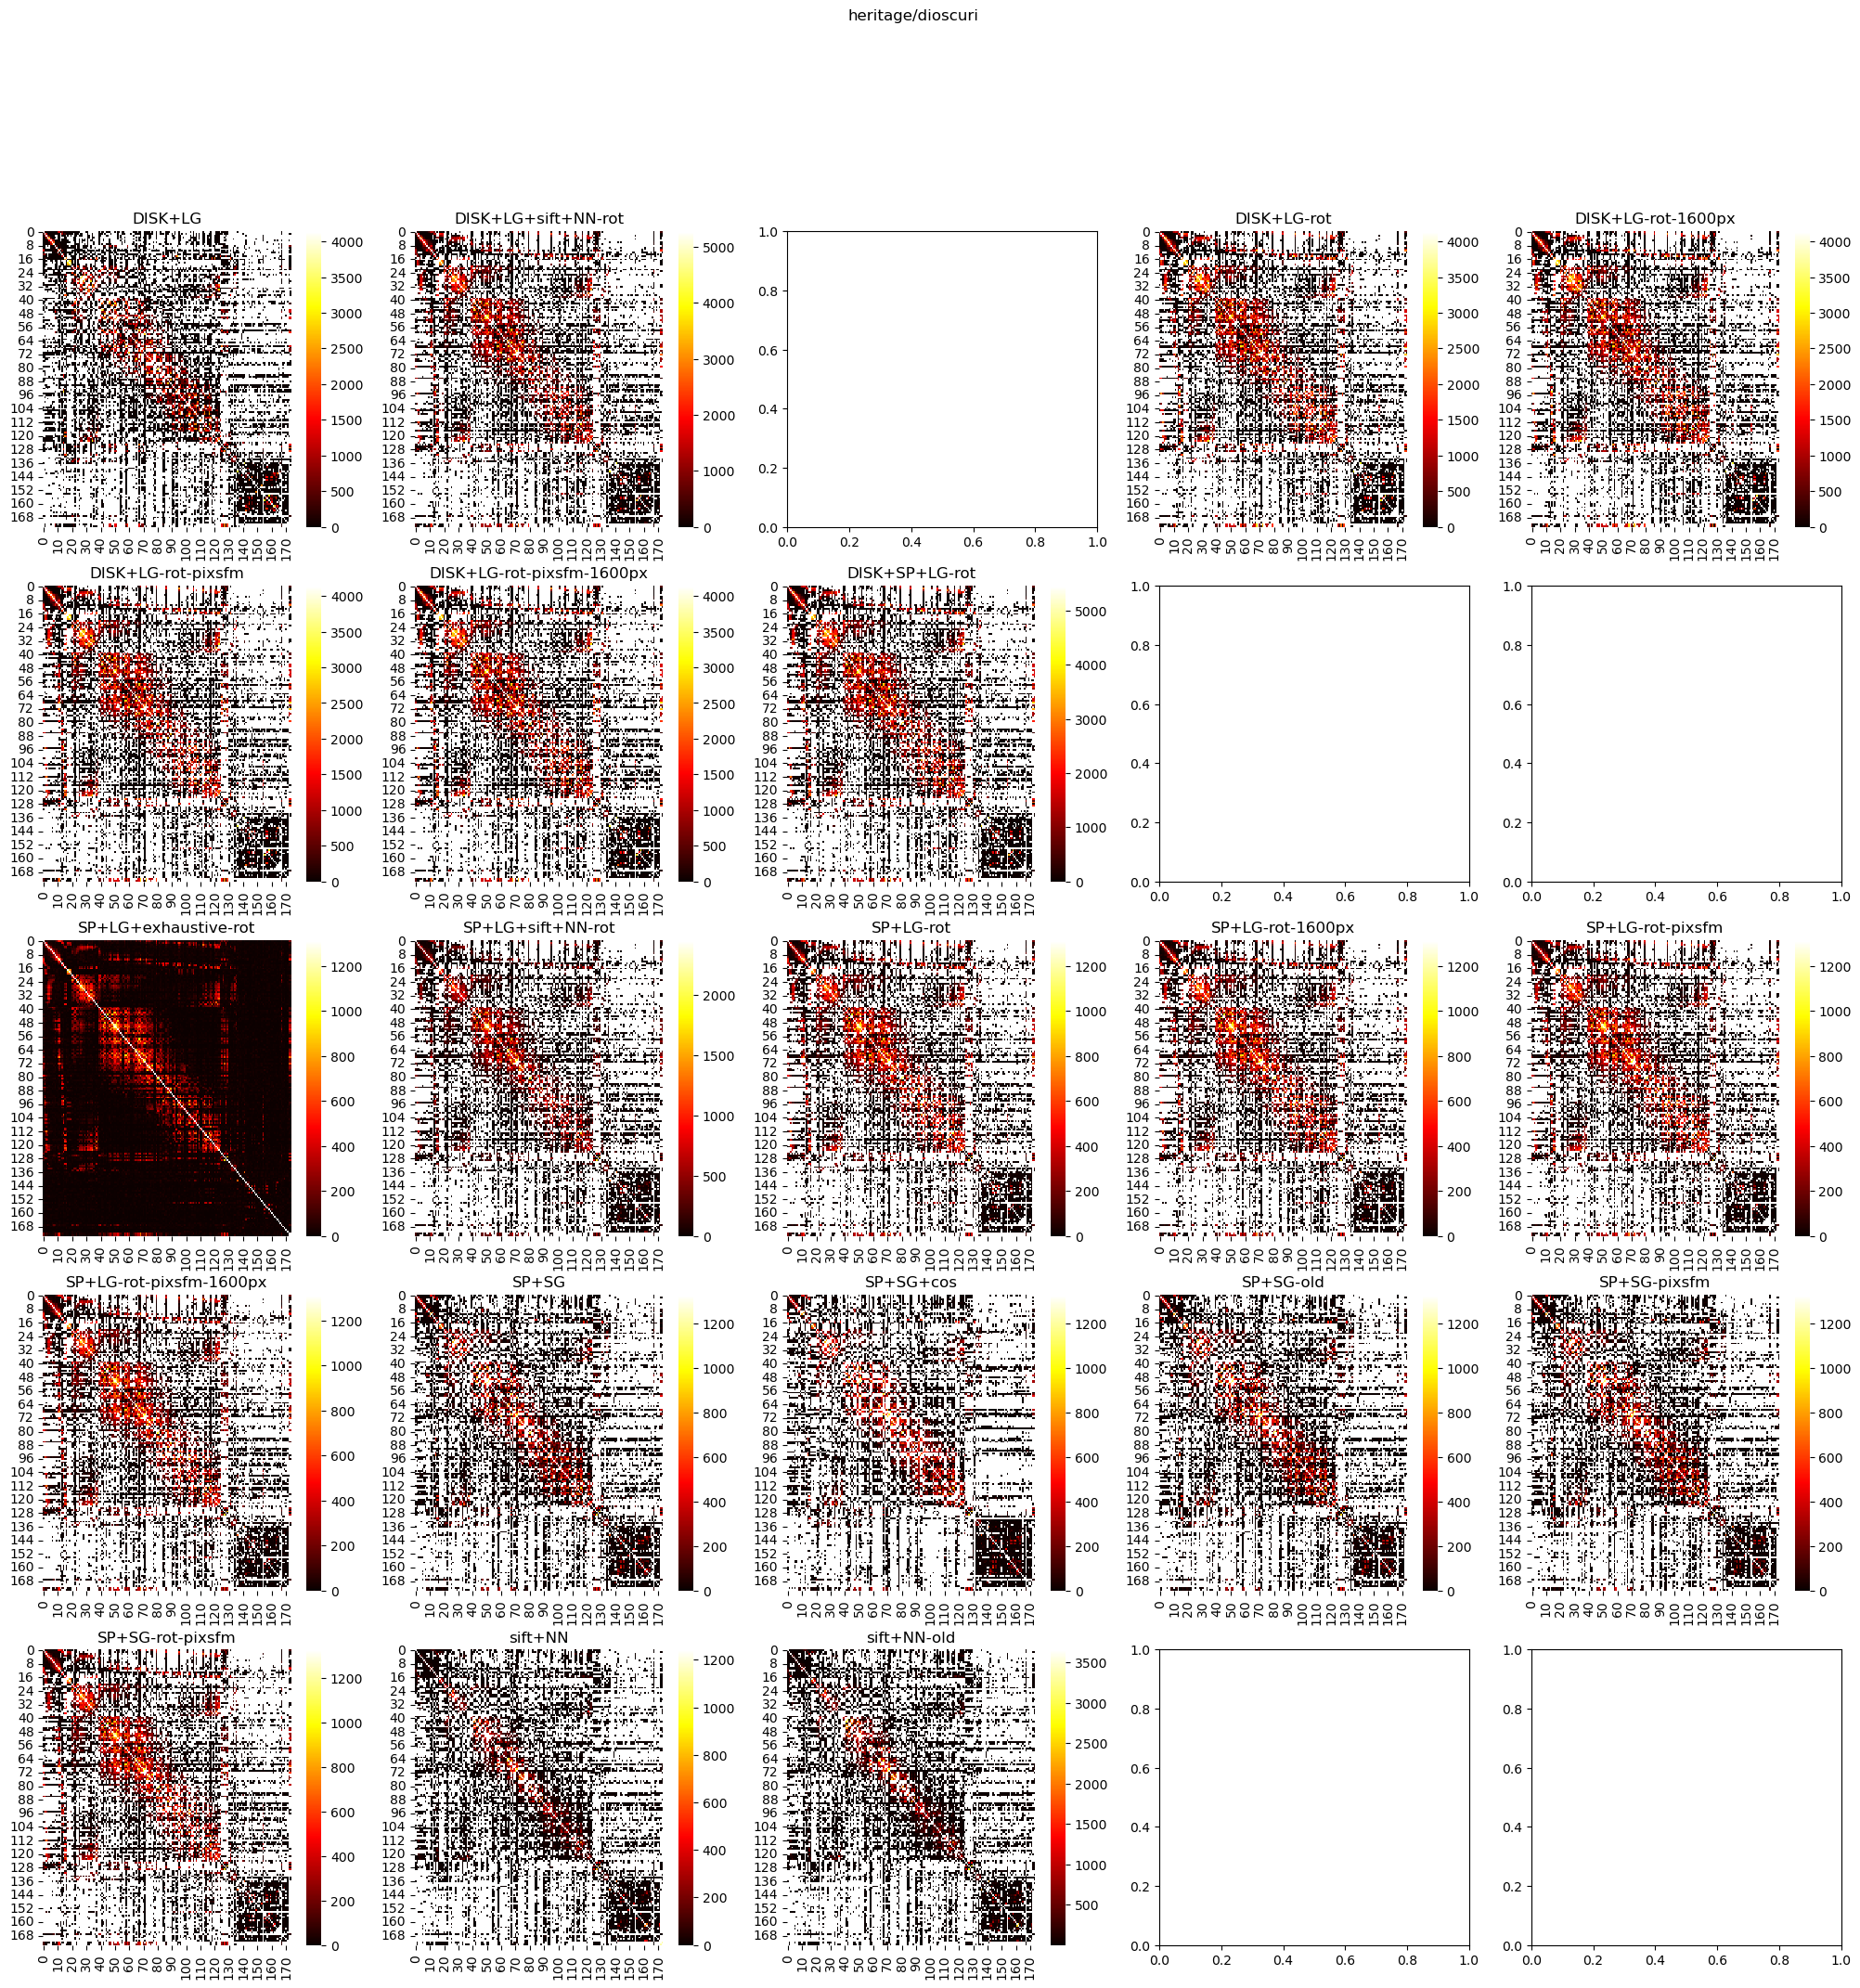

heritage/wall: 100%|██████████| 23/23 [00:17<00:00,  1.34it/s]


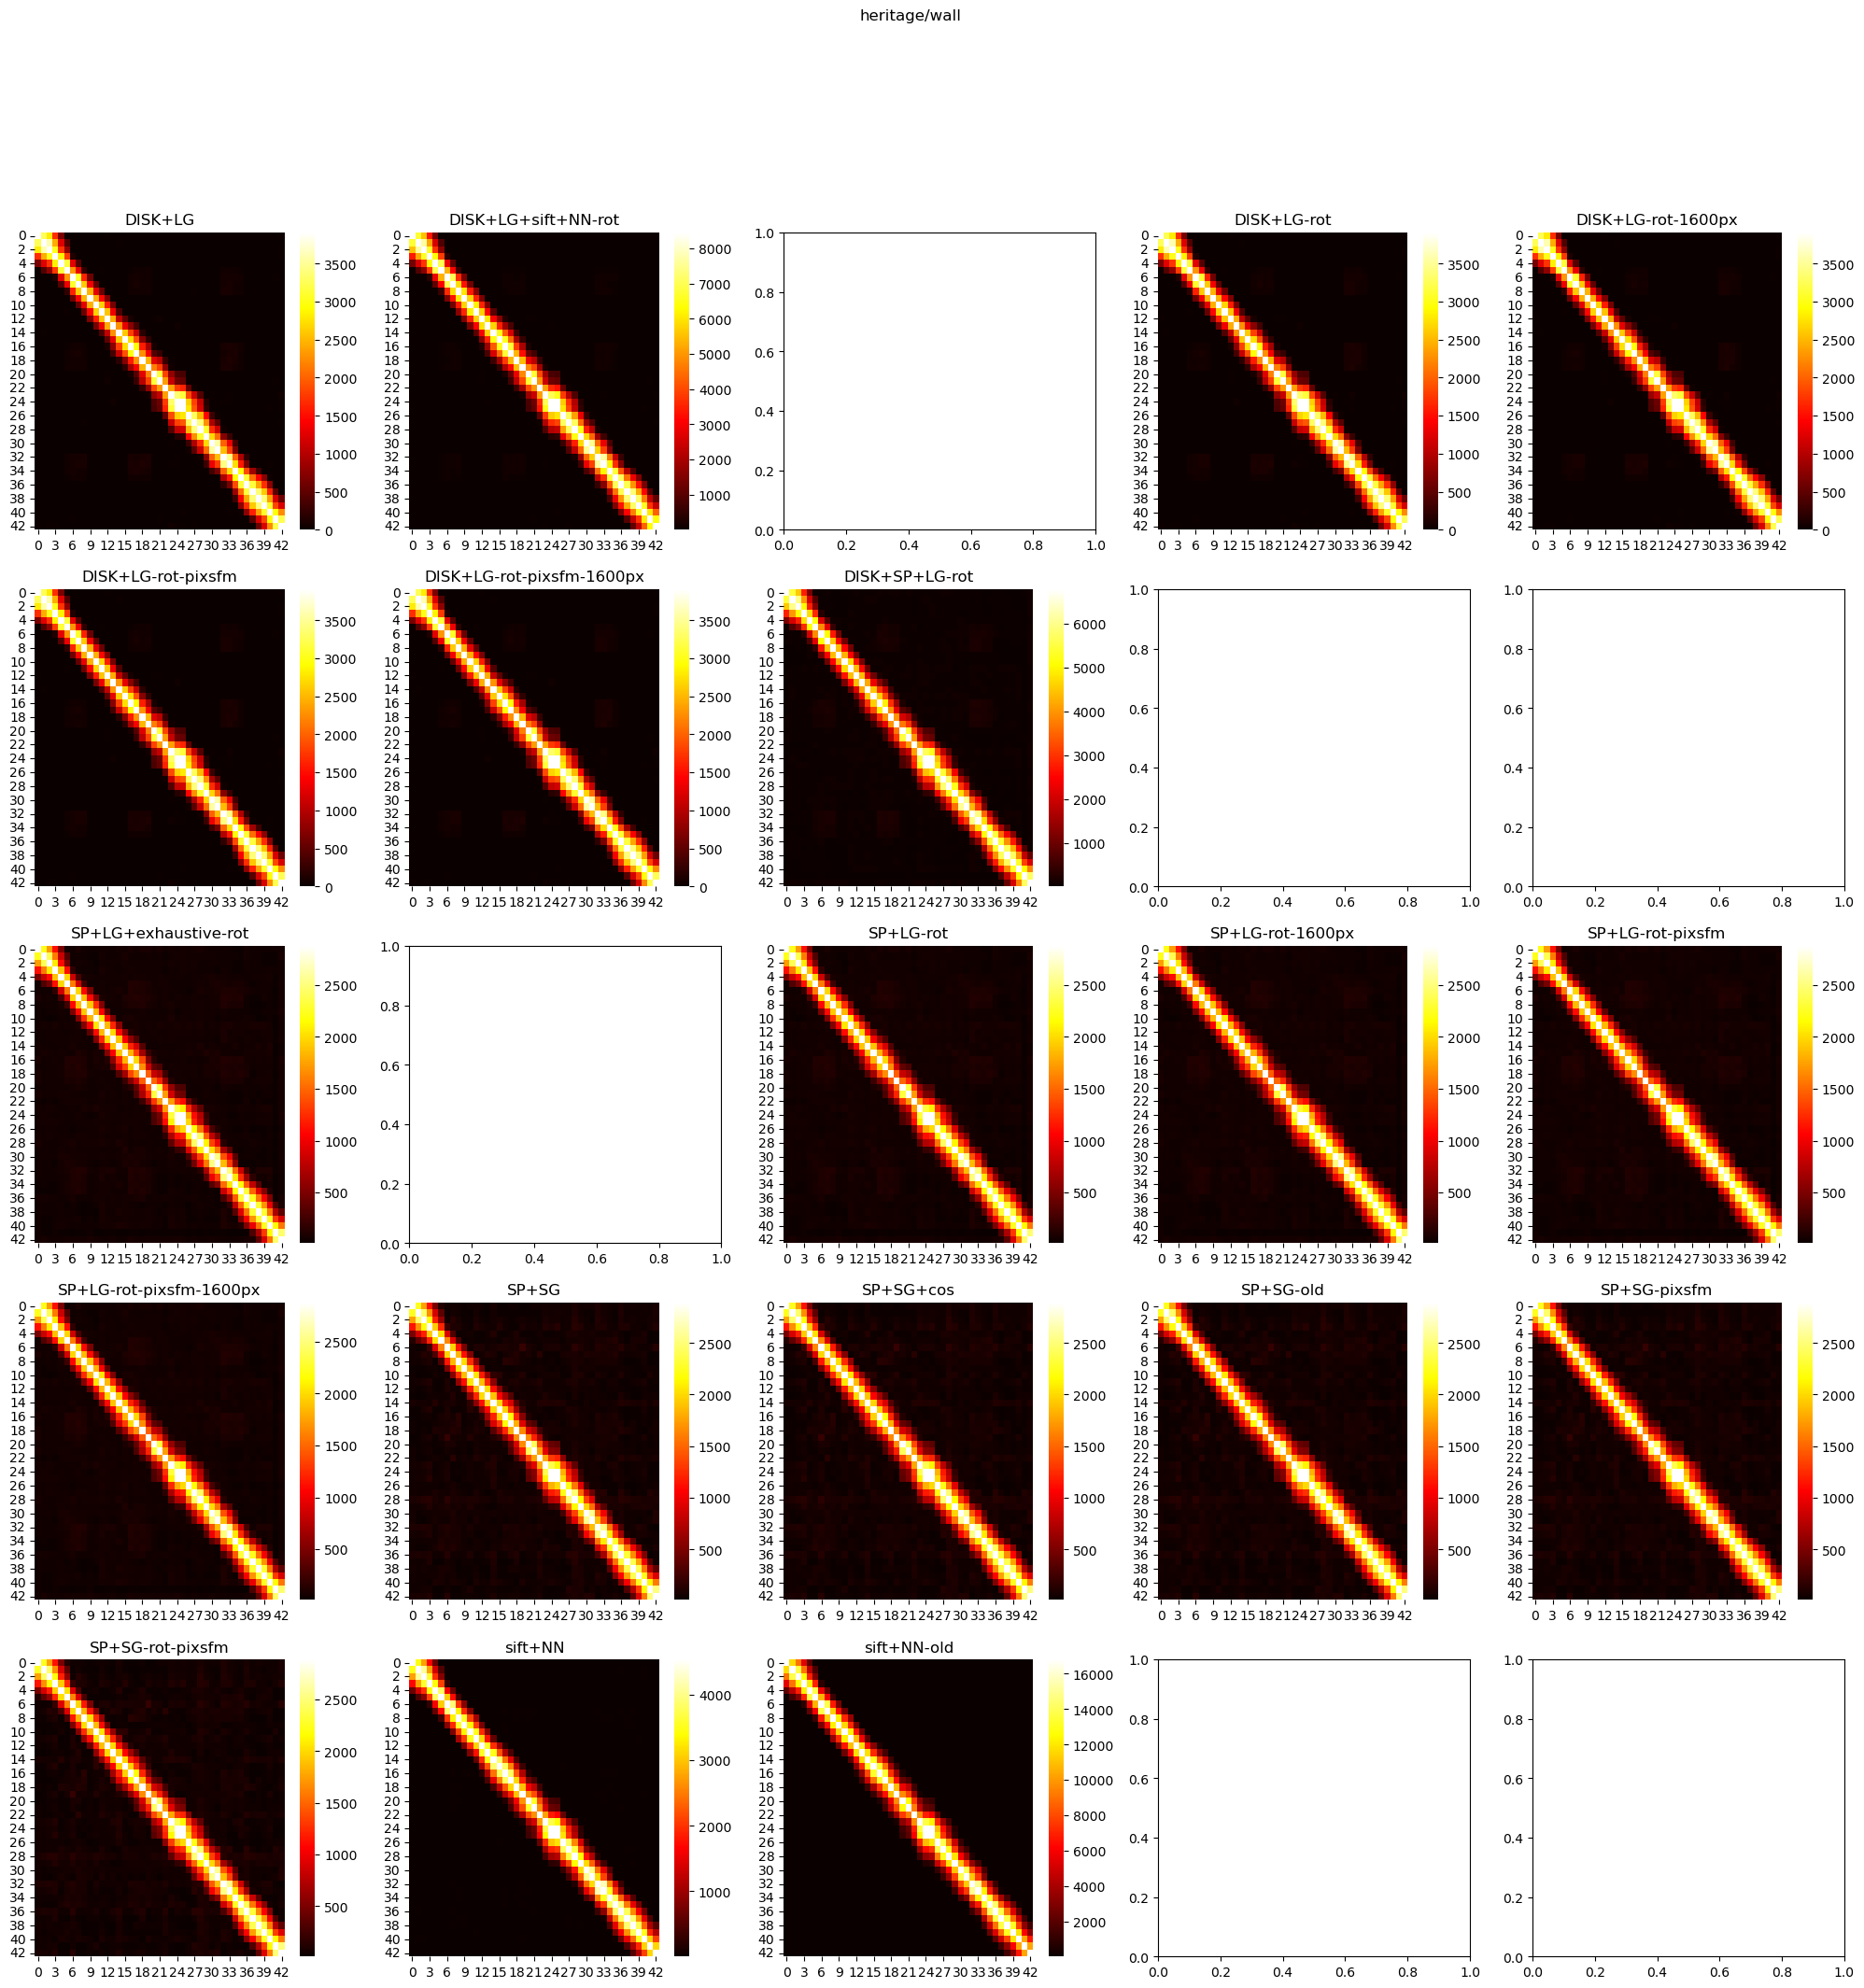

haiper/bike: 100%|██████████| 23/23 [00:07<00:00,  3.15it/s]


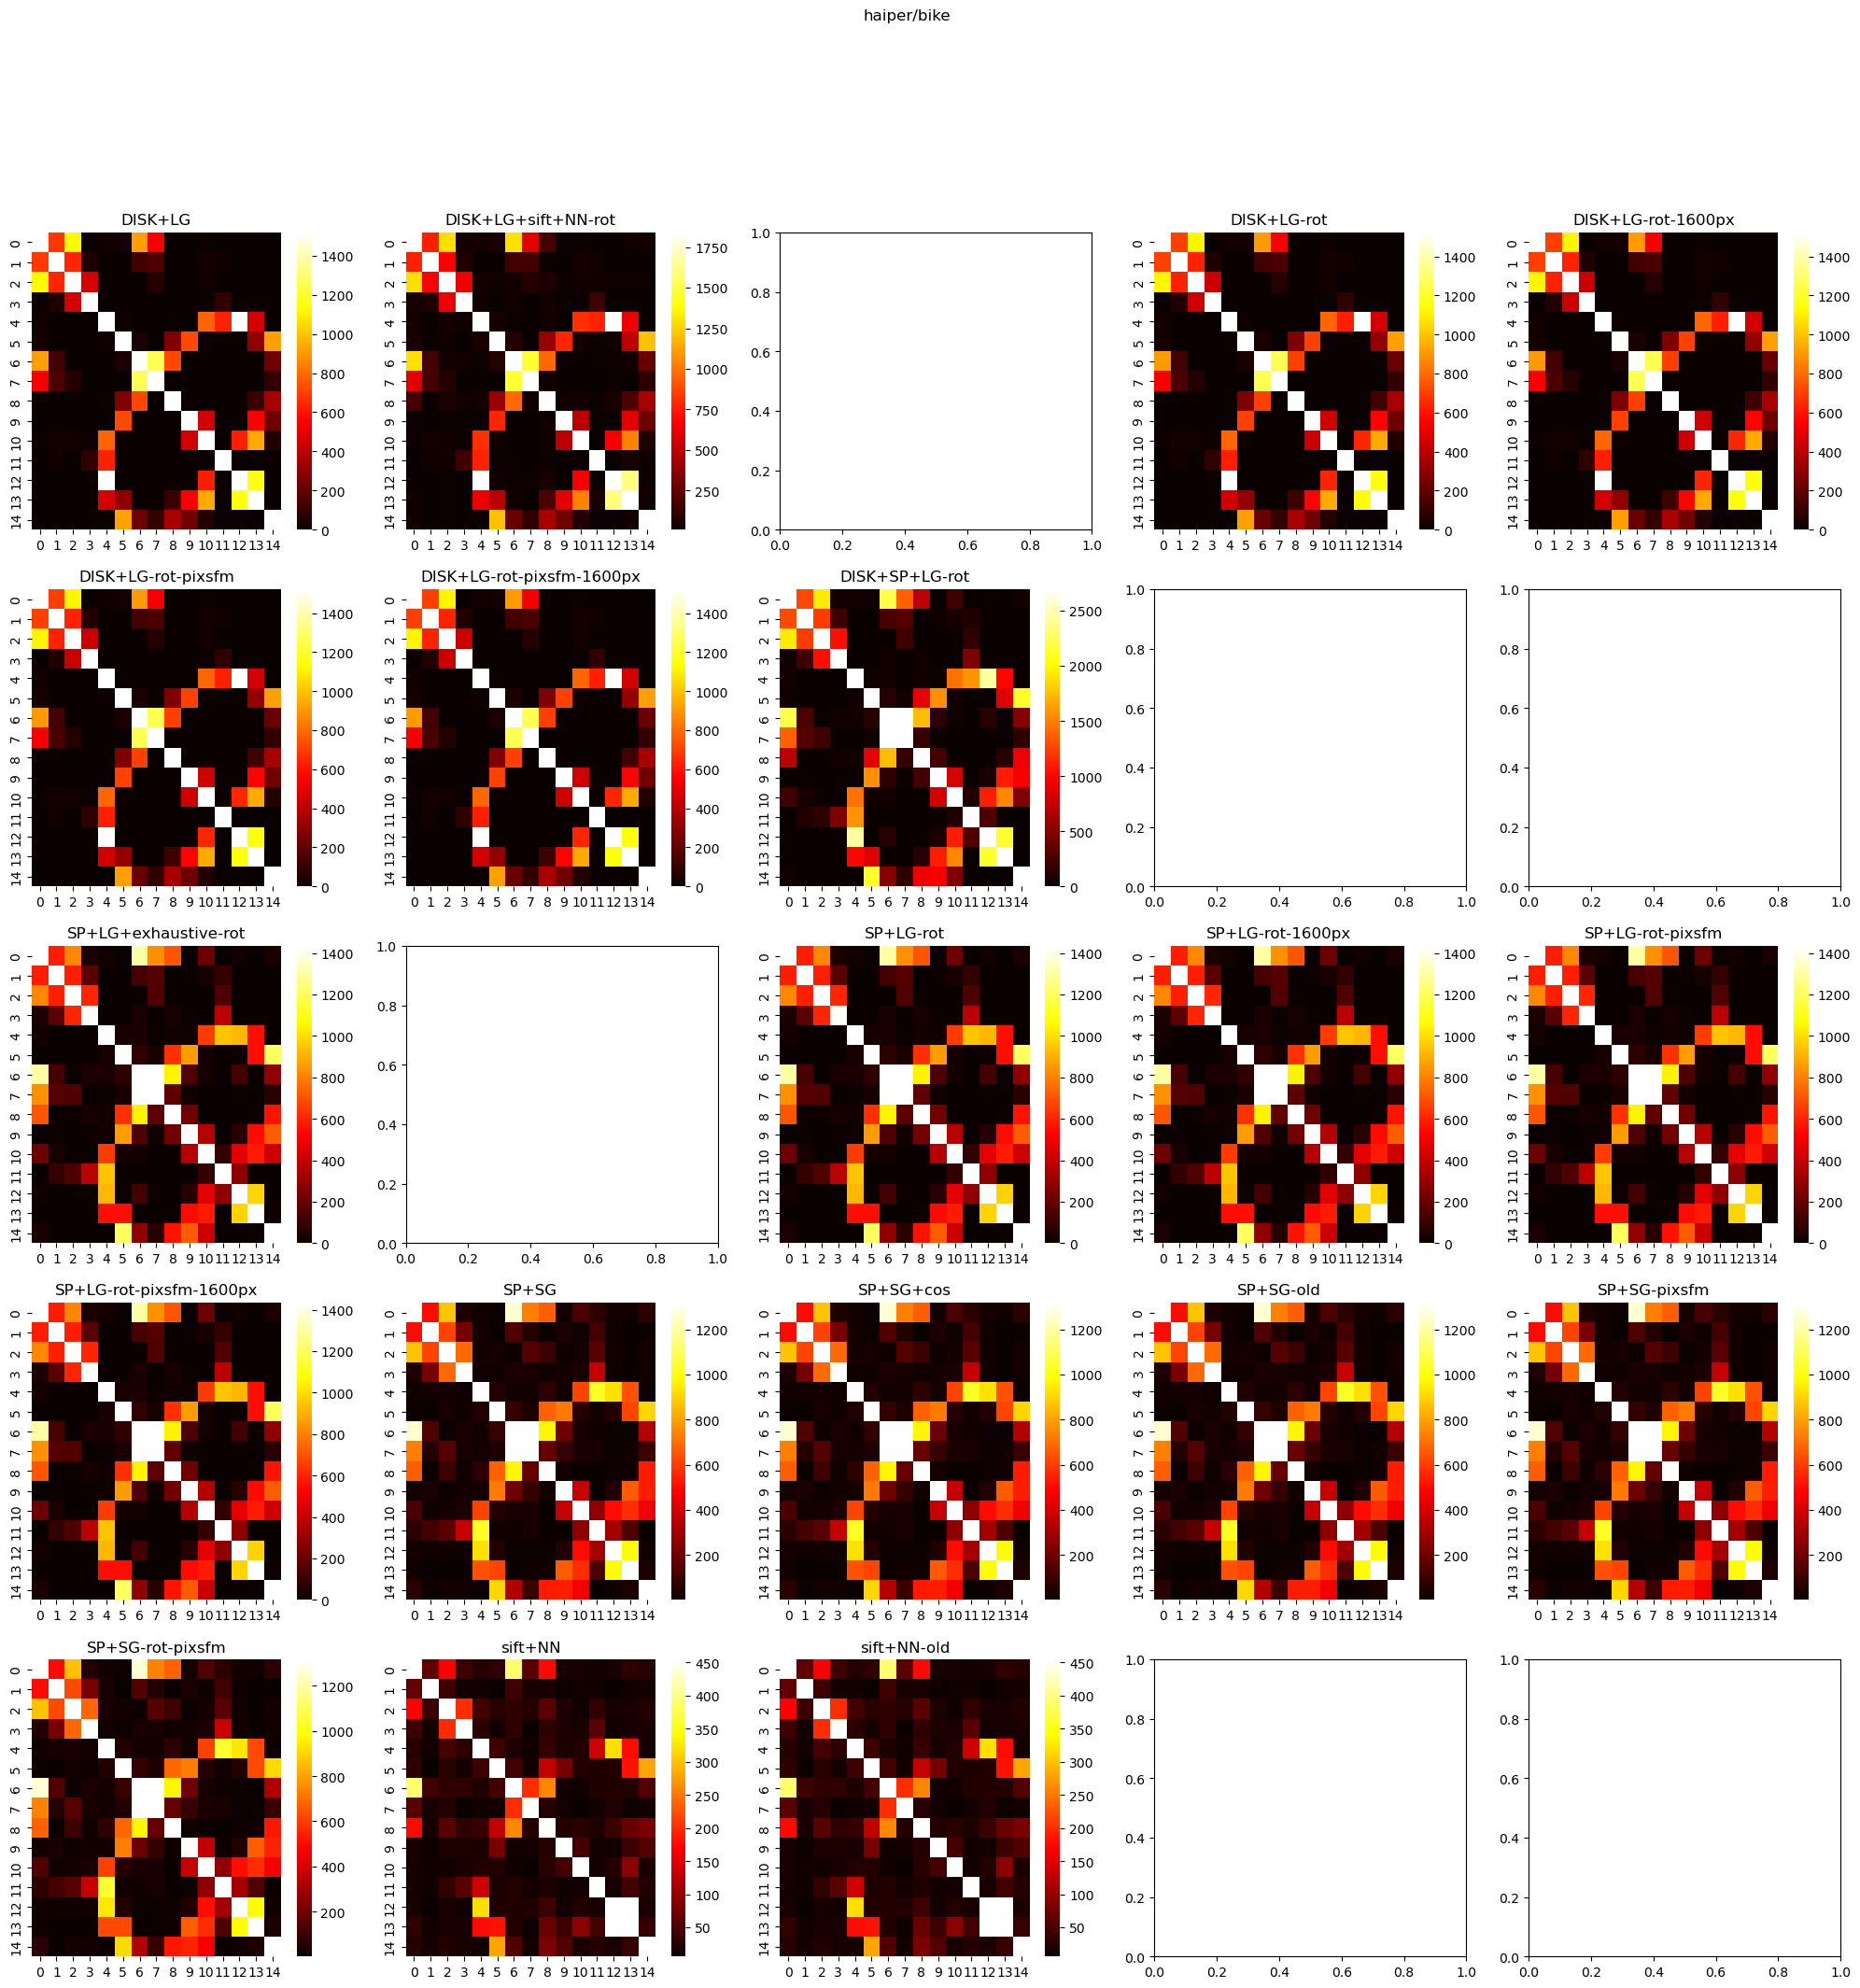

haiper/chairs: 100%|██████████| 23/23 [00:07<00:00,  2.99it/s]


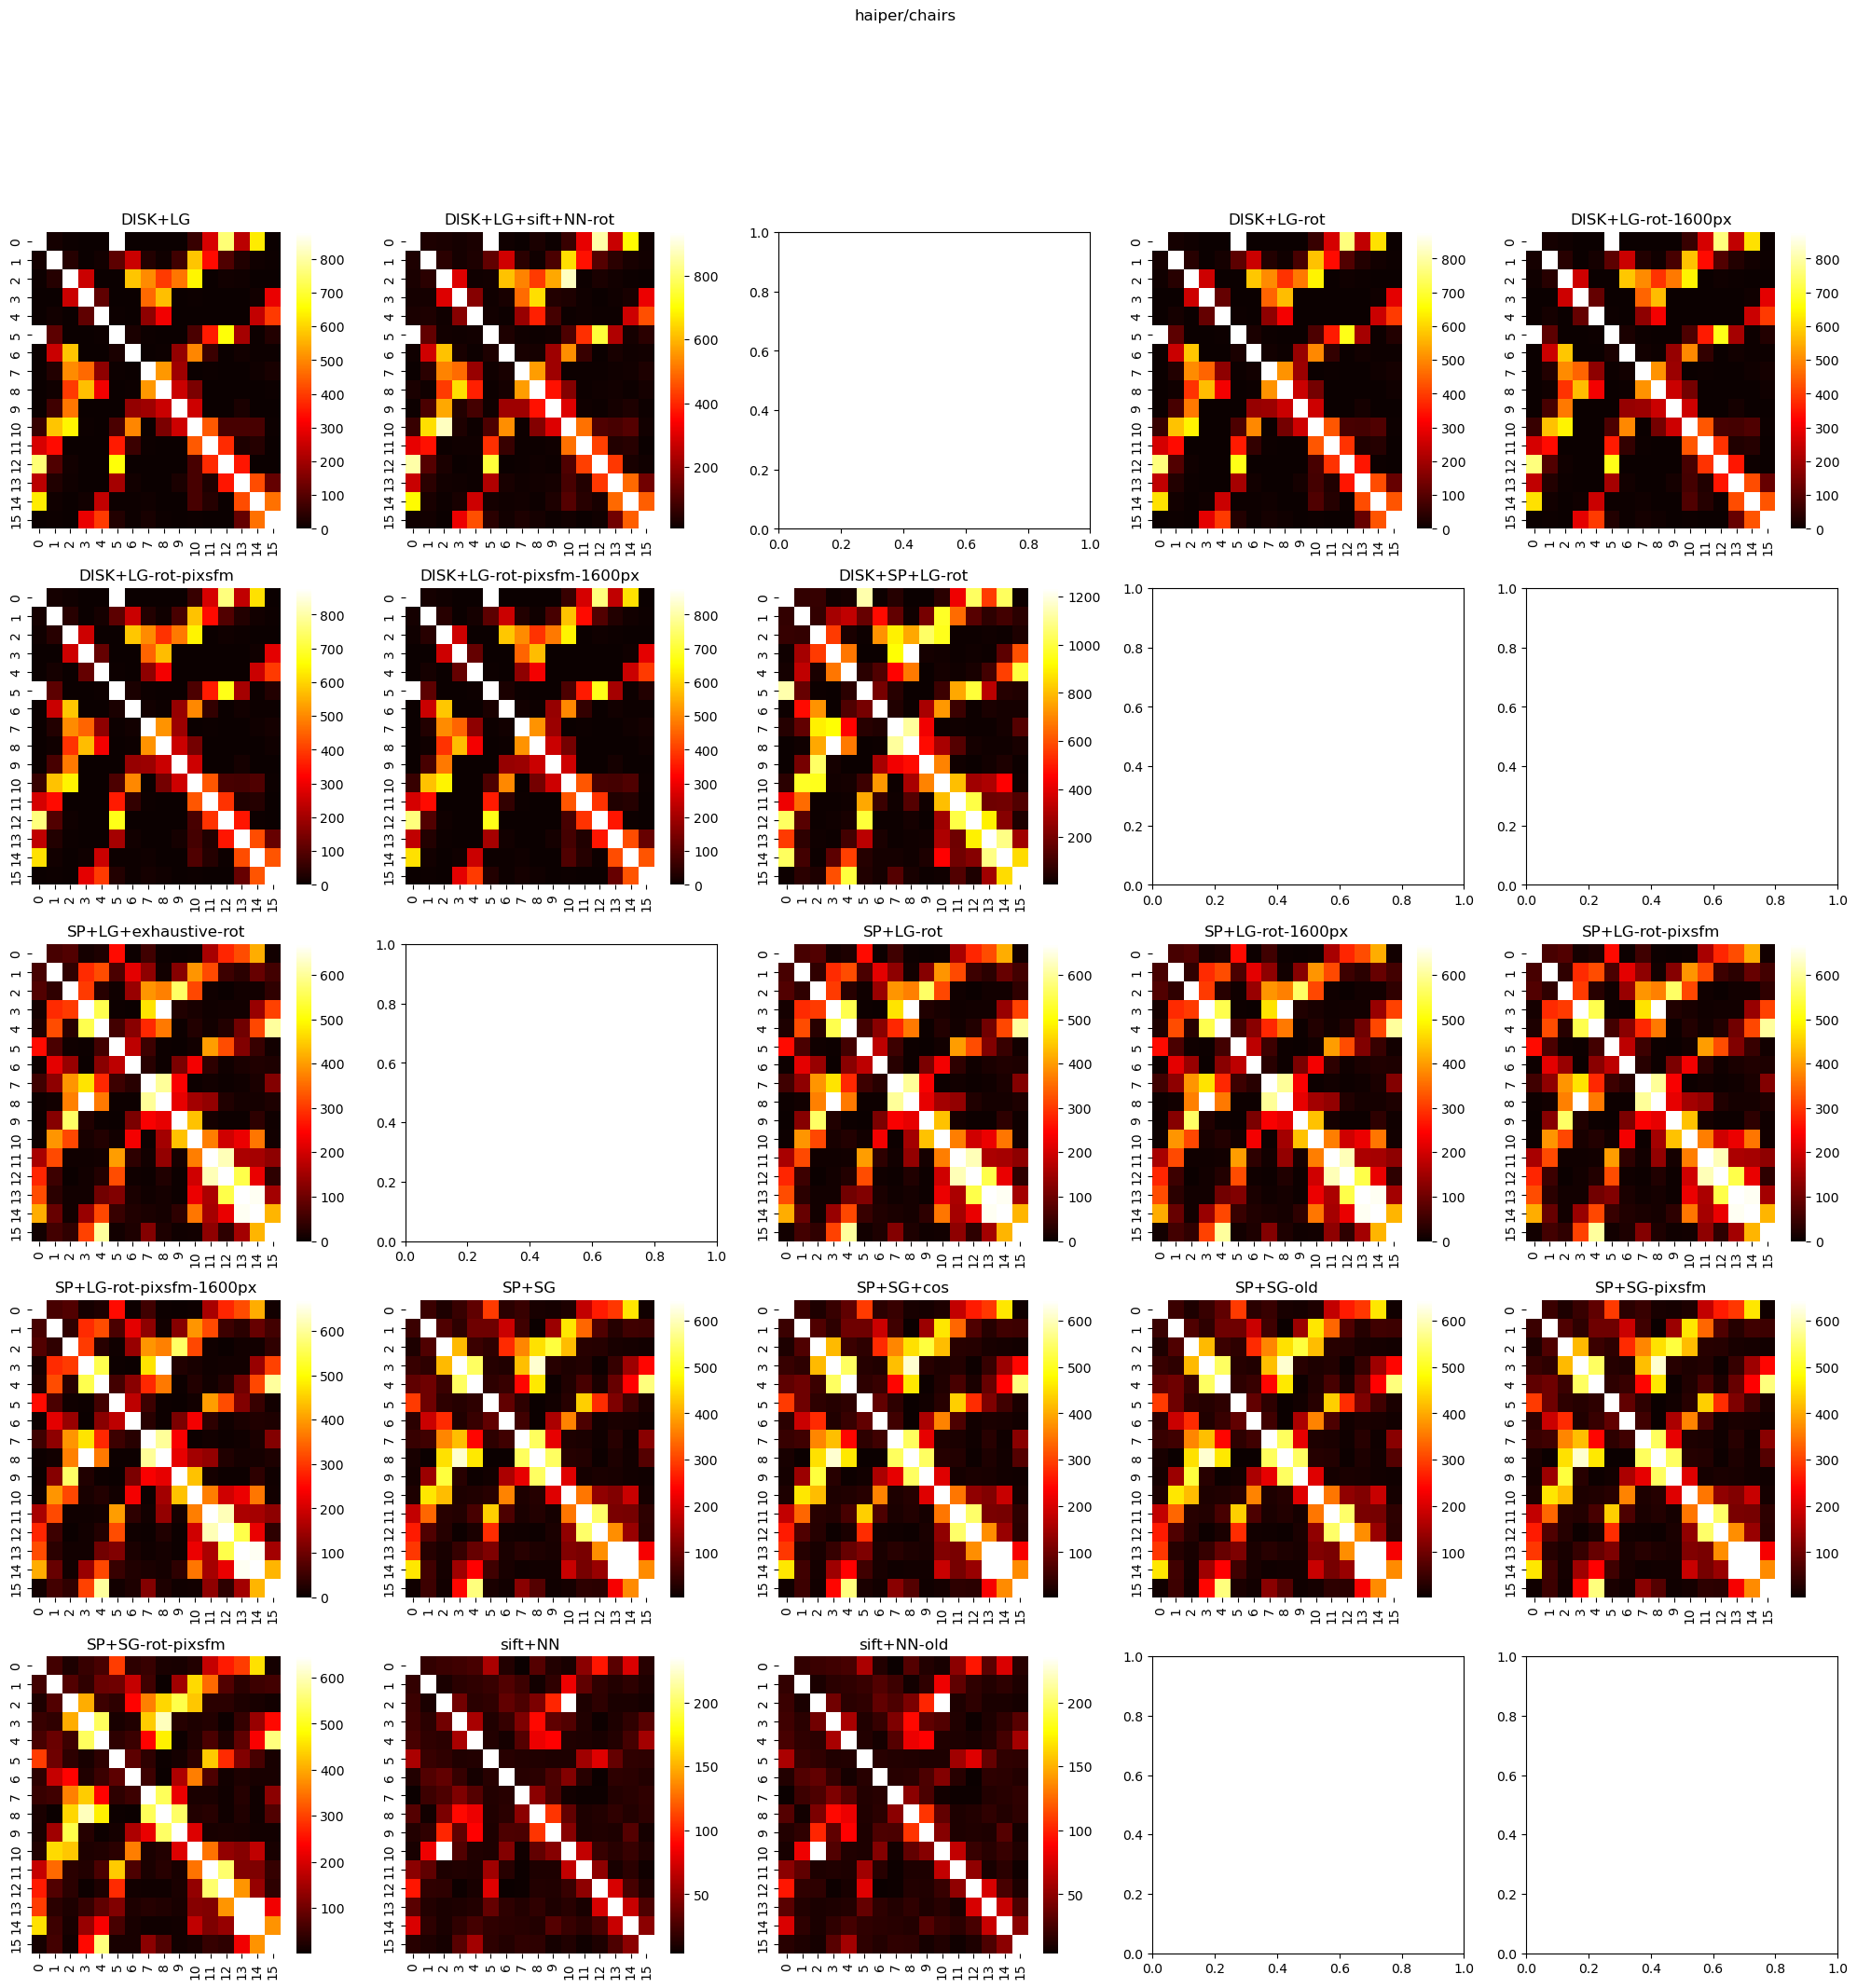

haiper/fountain: 100%|██████████| 23/23 [00:07<00:00,  2.89it/s]


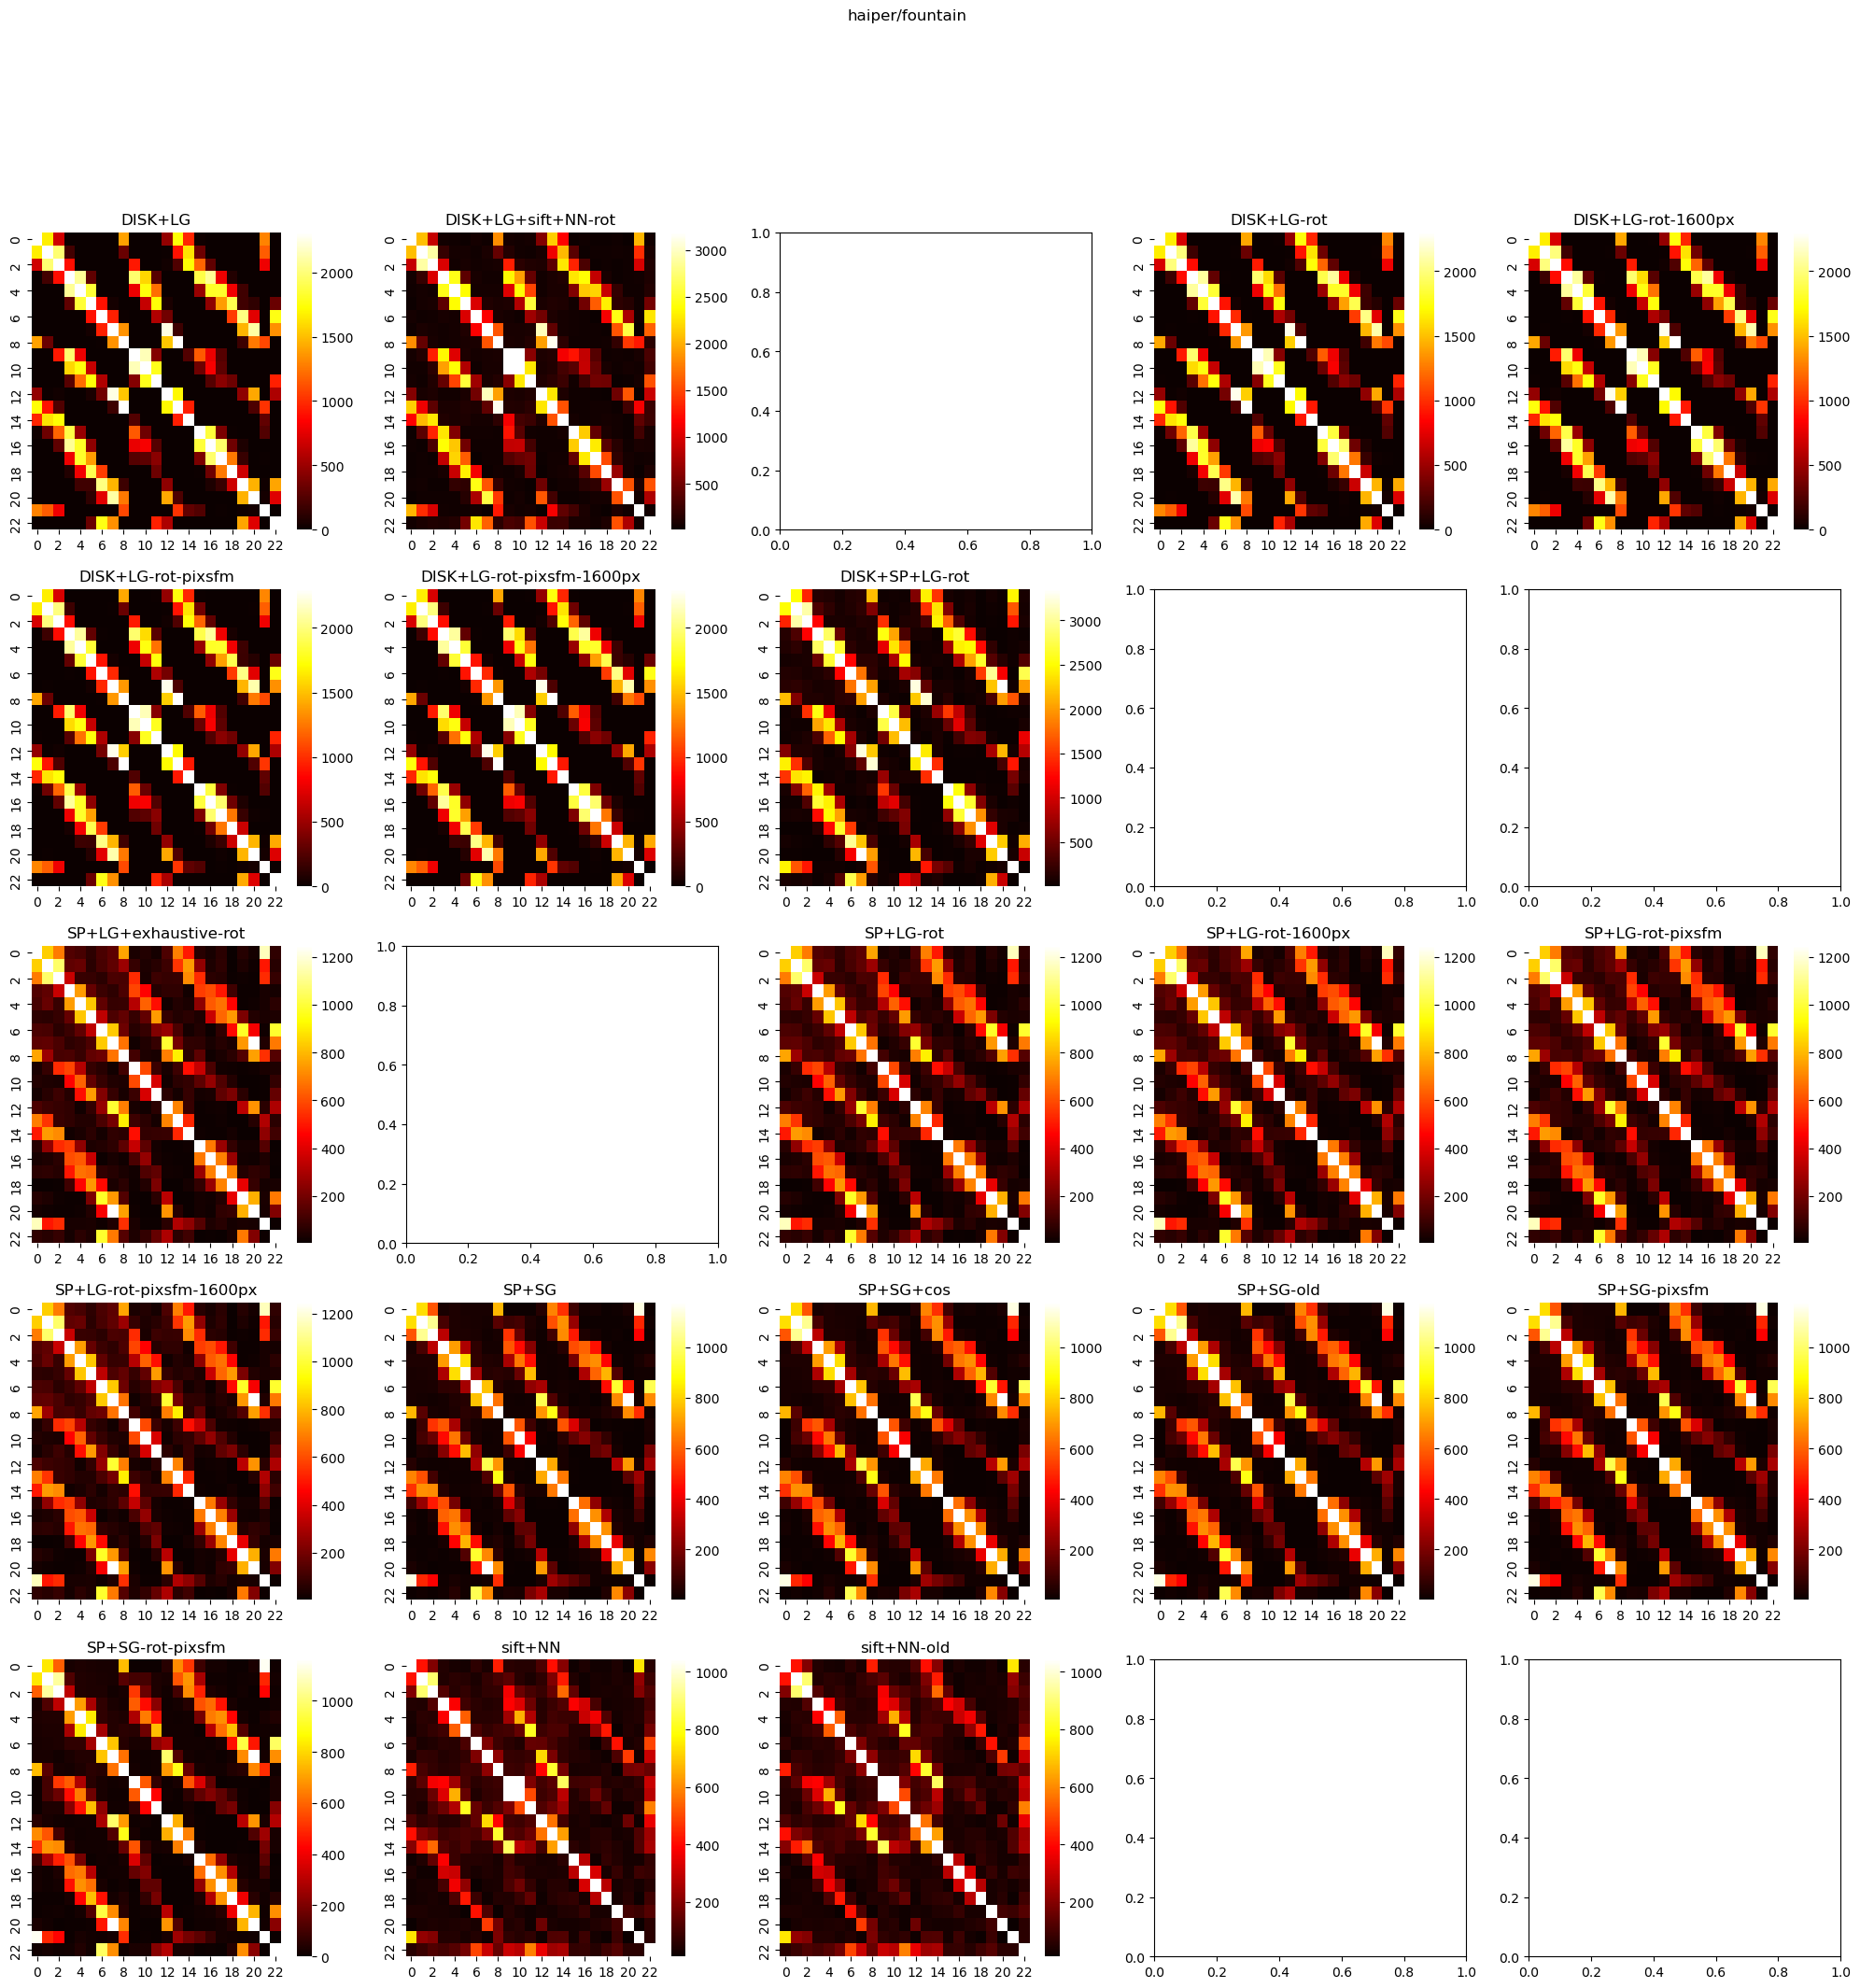

urban/kyiv-puppet-theater: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]


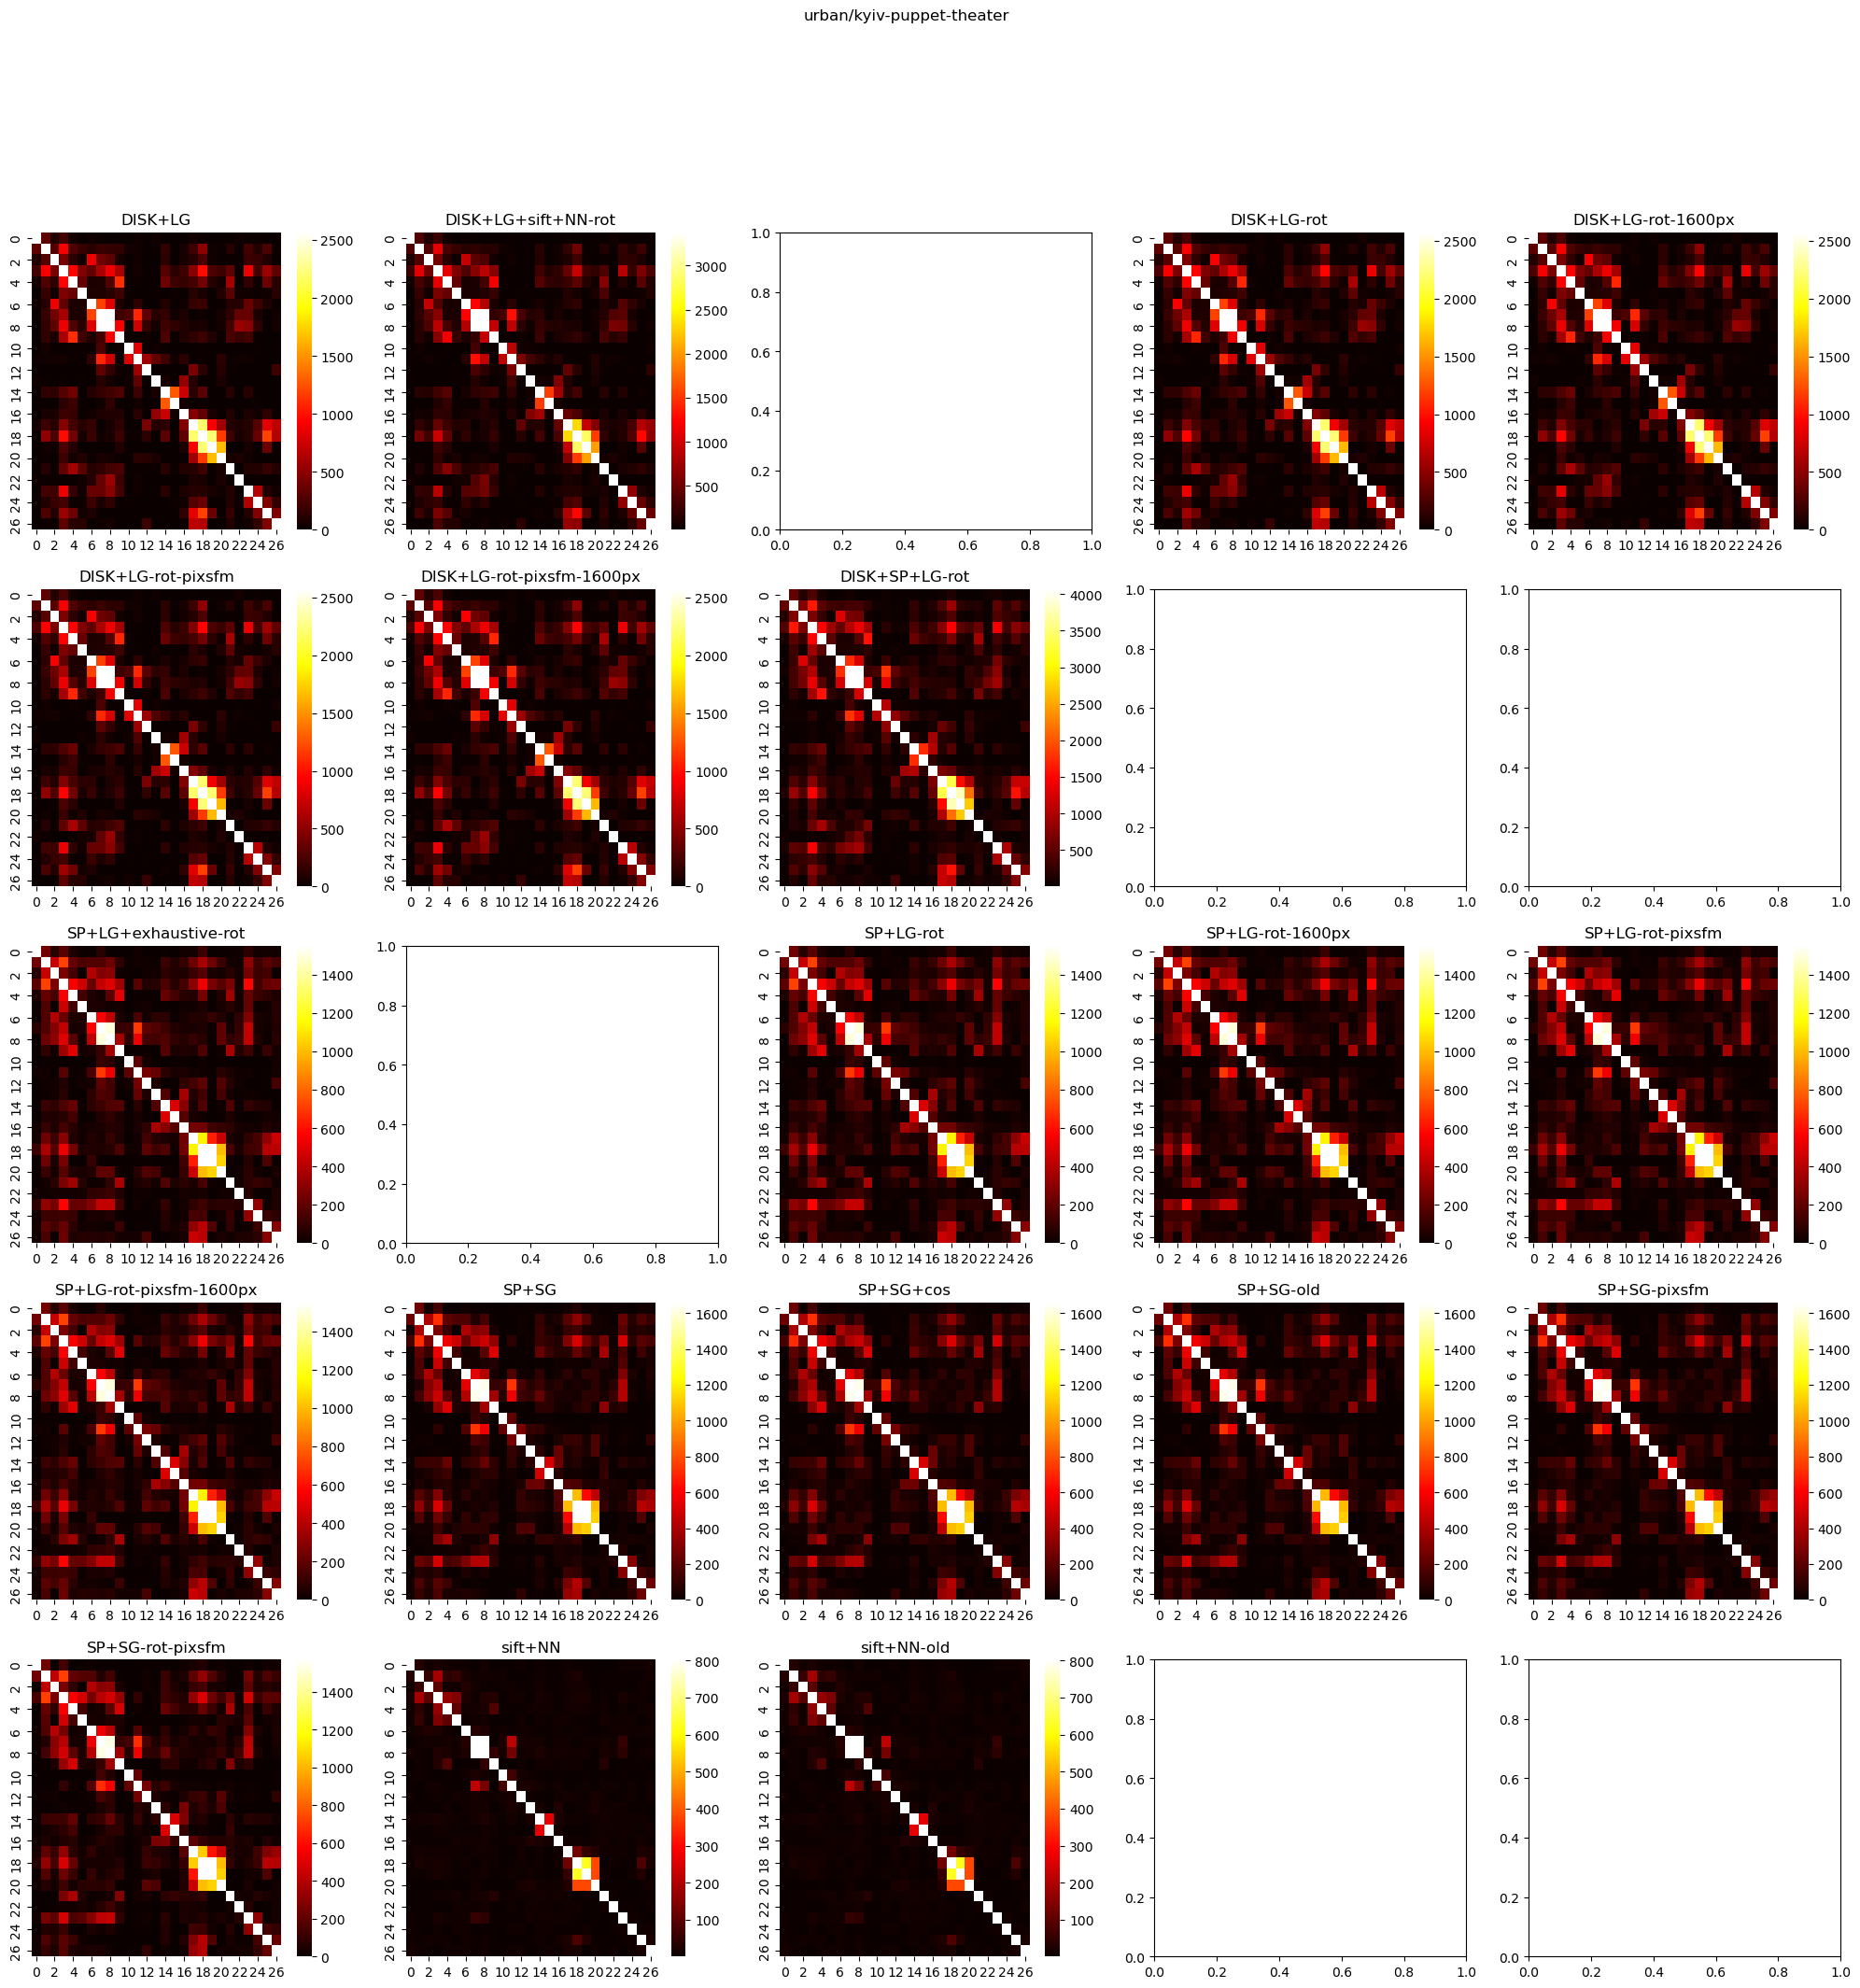

In [50]:

for i, ds in enumerate(datasets.keys()):
    for j, scene in enumerate(datasets[ds]):
        image_names = metrics[ds][scene]["images"]

        pbar = tqdm(runs, desc=f"{ds}/{scene}")
        
        rows = np.sqrt(len(runs))
        cols = np.ceil(len(runs) / rows)
        fig, ax = plt.subplots(int(rows+1), int(cols), figsize=(5 * cols, 5 * rows))

        for r_idx, r in enumerate(pbar):

            scene_dir = Path(f"{out_dir}/{r}/{ds}/{scene}")

            matches = scene_dir / "matches.h5"

            if not matches.exists():
                continue


            pairs = sorted(list_h5_names(matches))
            
            match_matrix = -np.ones([len(image_names), len(image_names)])
            for pair in pairs:
                name0, name1 = pair.split("/")
                idx0, idx1 = image_names.index(name0), image_names.index(name1)
                m, sc = get_matches(matches, name0, name1)
                match_matrix[idx0, idx1] = match_matrix[idx1, idx0] = m.shape[0]

            # ax = sns.heatmap(match_matrix, linewidth=0.0, cmap="hot", mask=match_matrix < 0)

            sns.heatmap(
                match_matrix,
                ax=ax[int(r_idx // cols), int(r_idx % cols)],
                cbar=True,
                cmap="hot",
                mask=match_matrix < 0,
            )

            ax[int(r_idx // cols), int(r_idx % cols)].set_title(r)

        plt.suptitle(f"{ds}/{scene}")
        plt.show()


heritage/cyprus: 100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


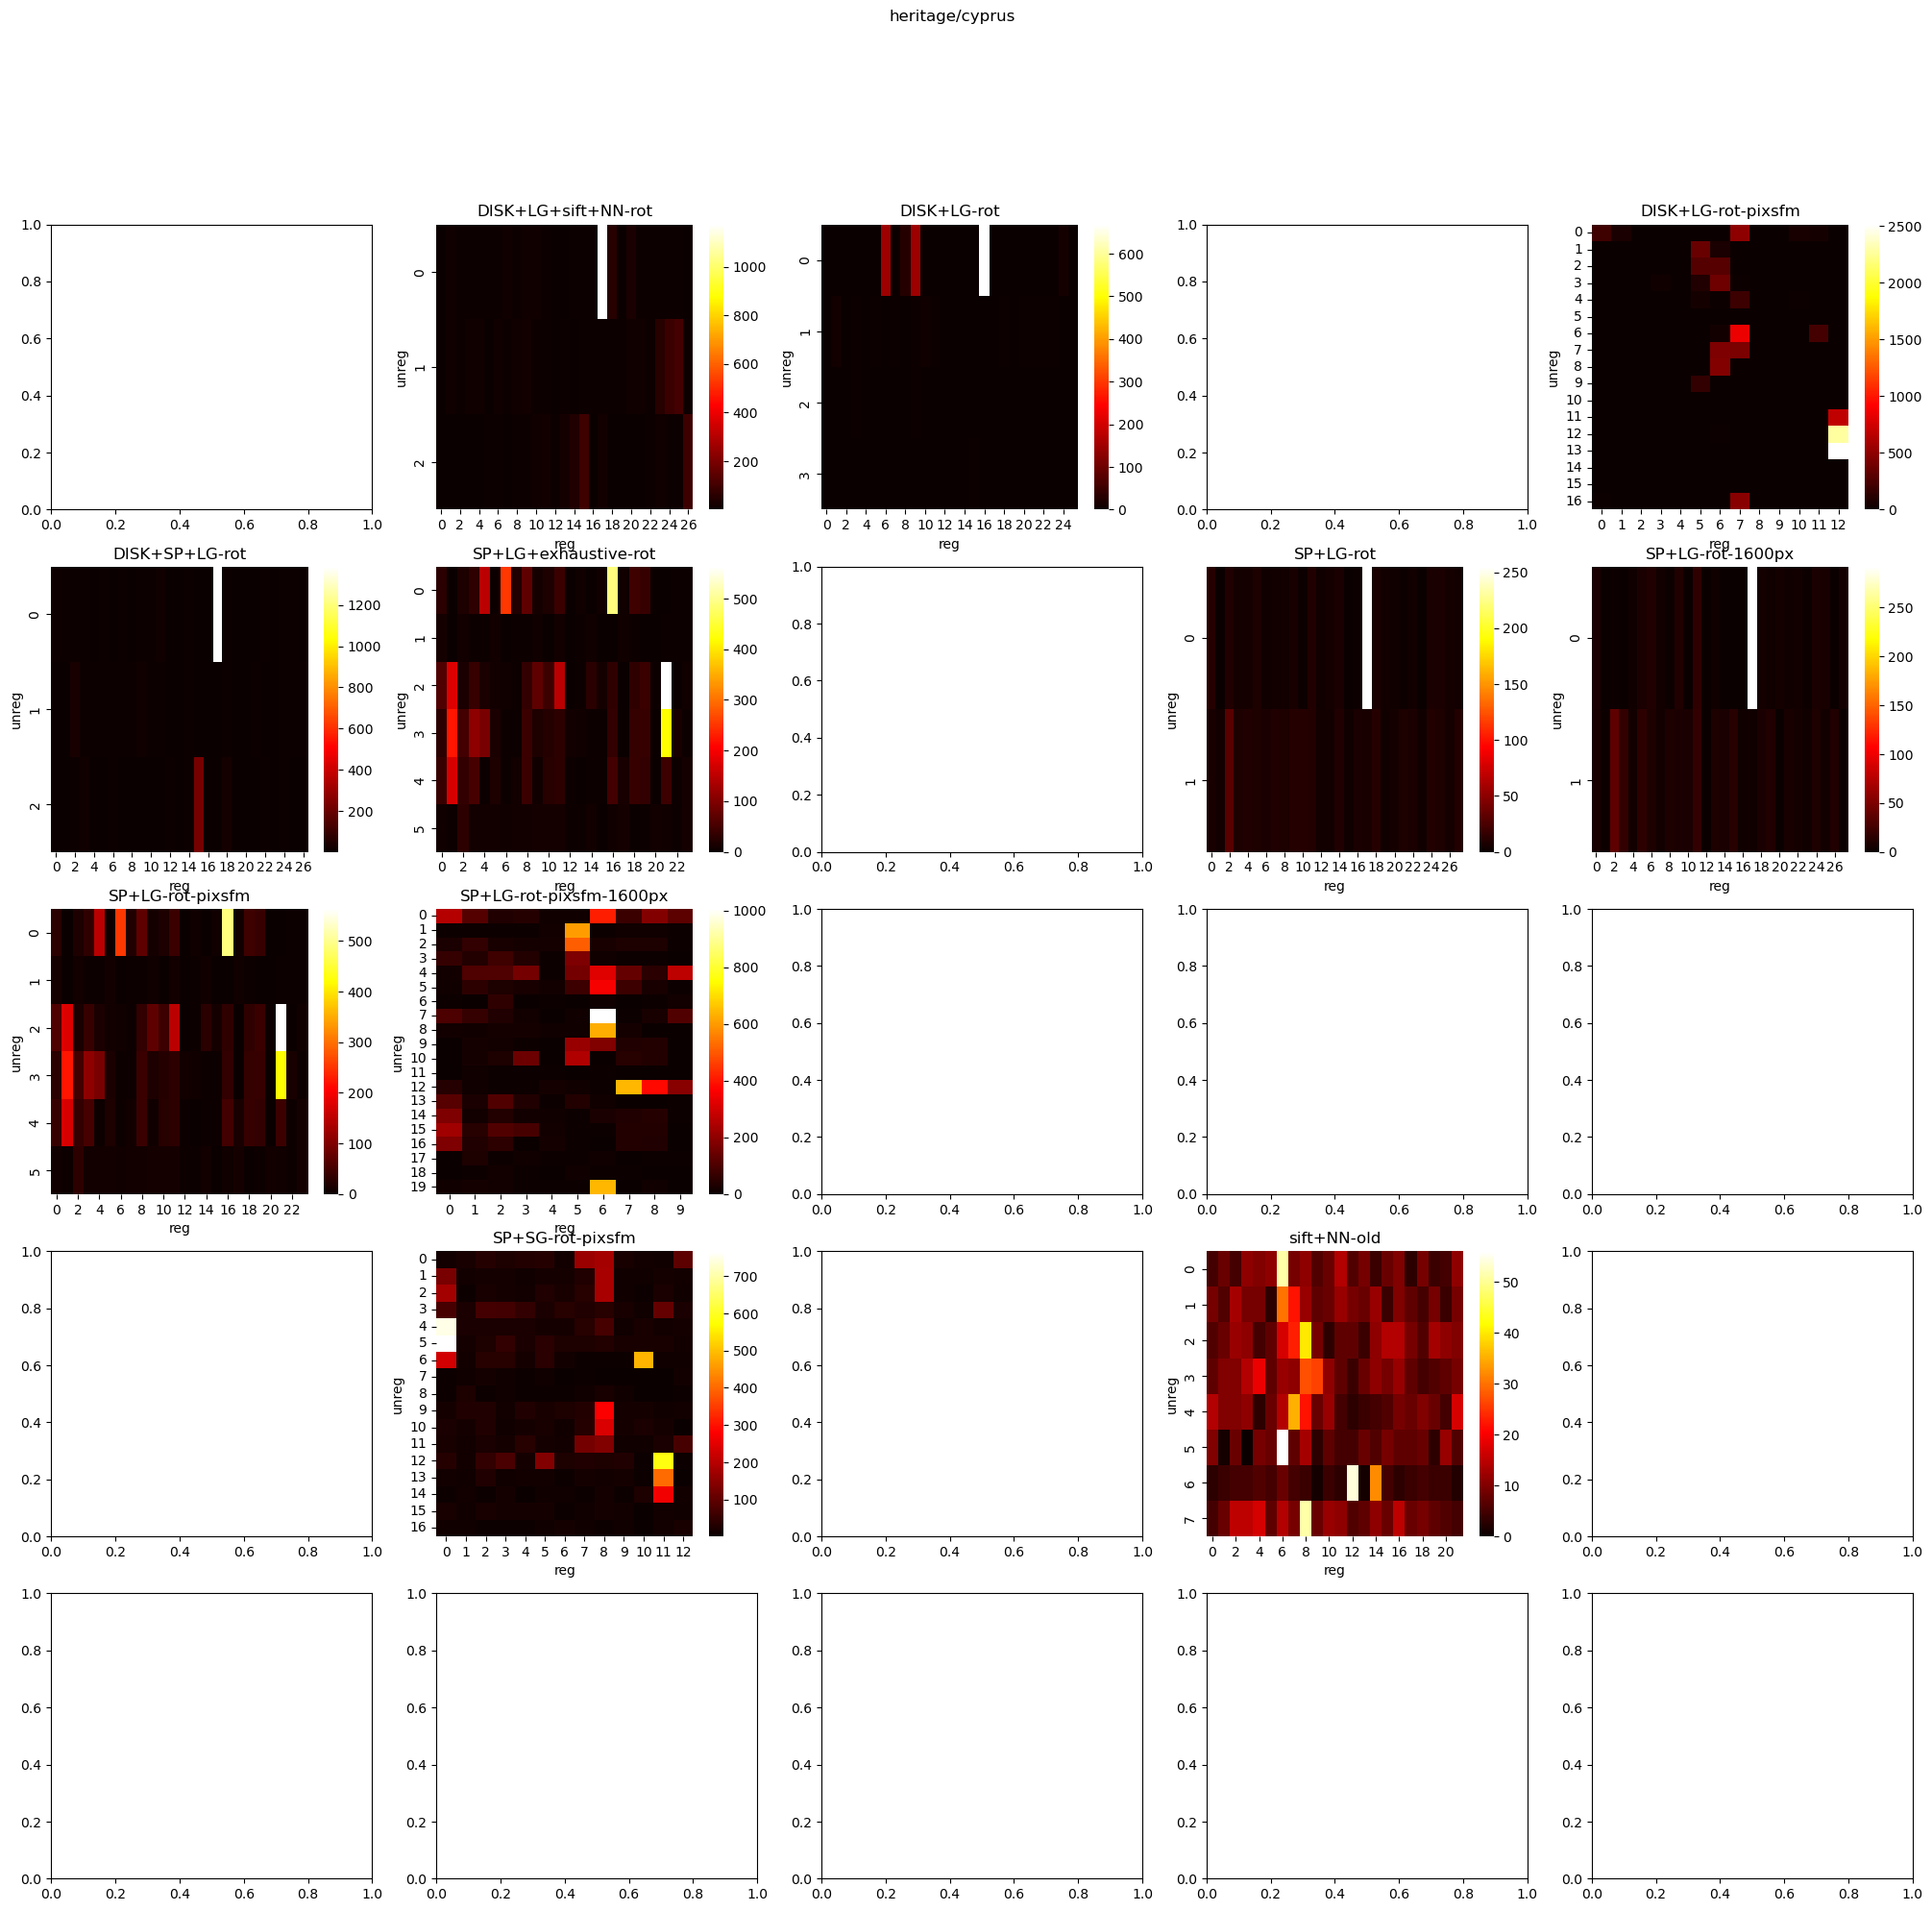

heritage/dioscuri: 100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


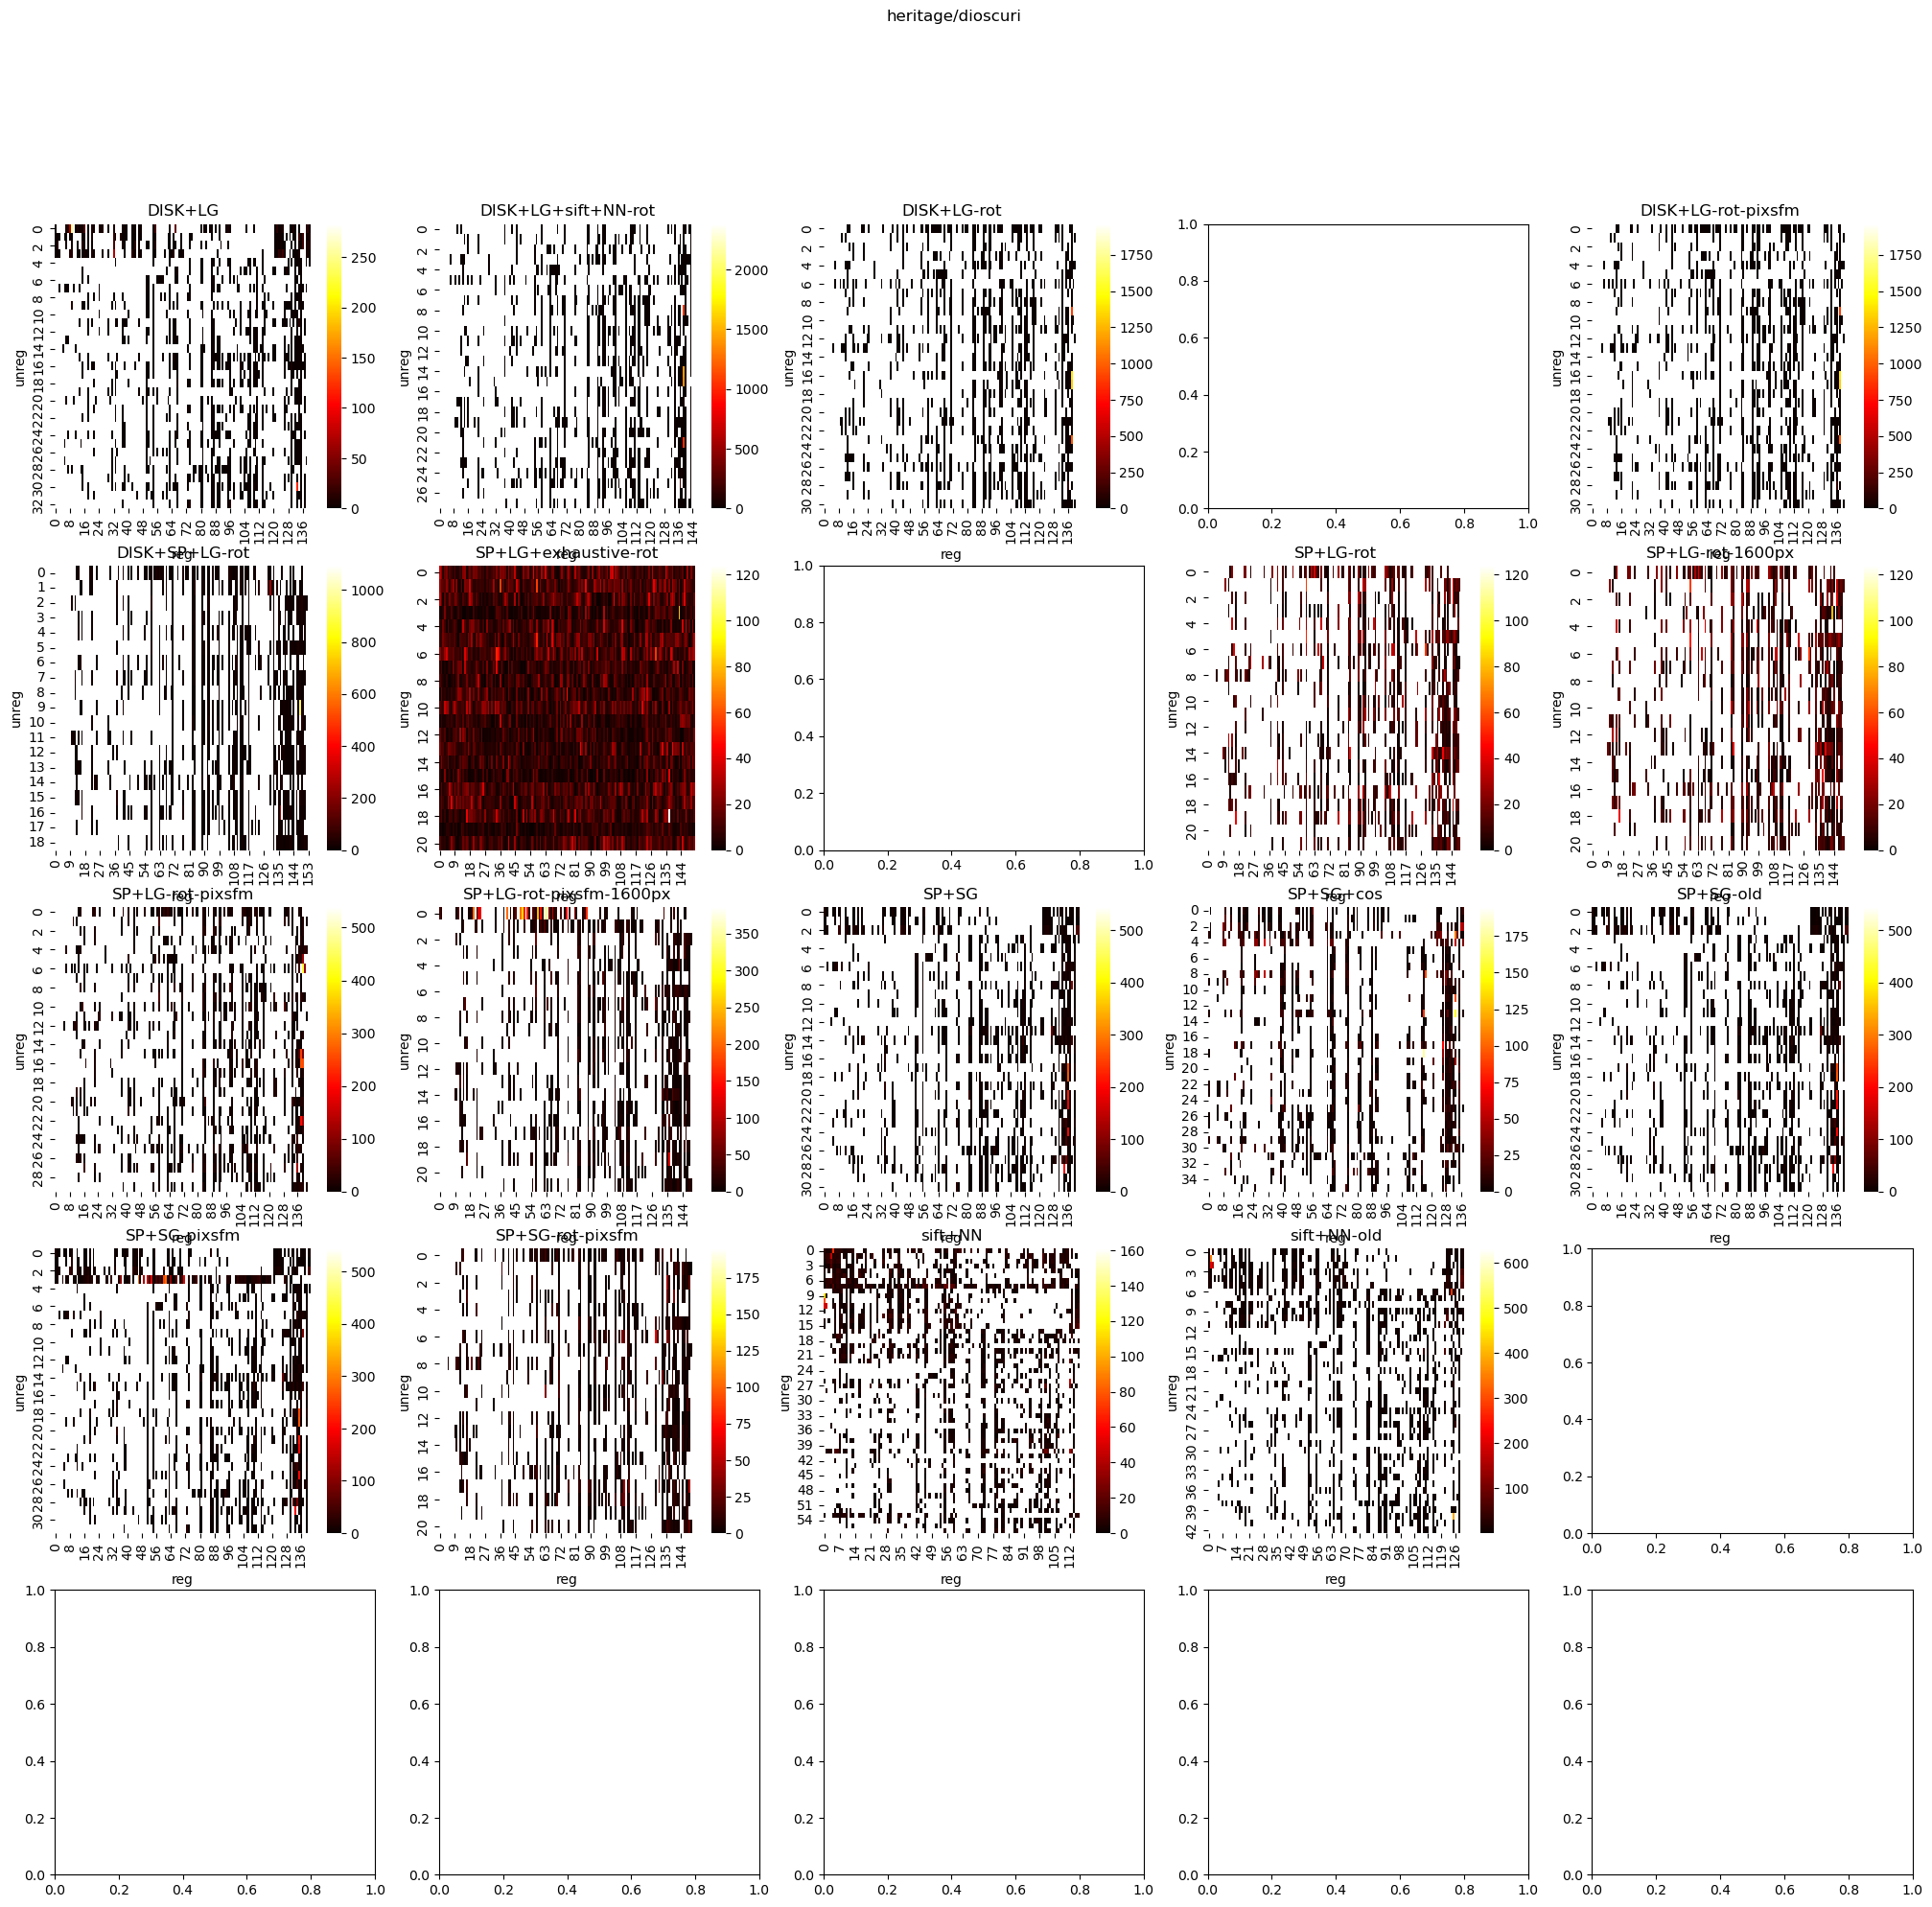

heritage/wall: 100%|██████████| 20/20 [00:00<00:00, 24.75it/s]


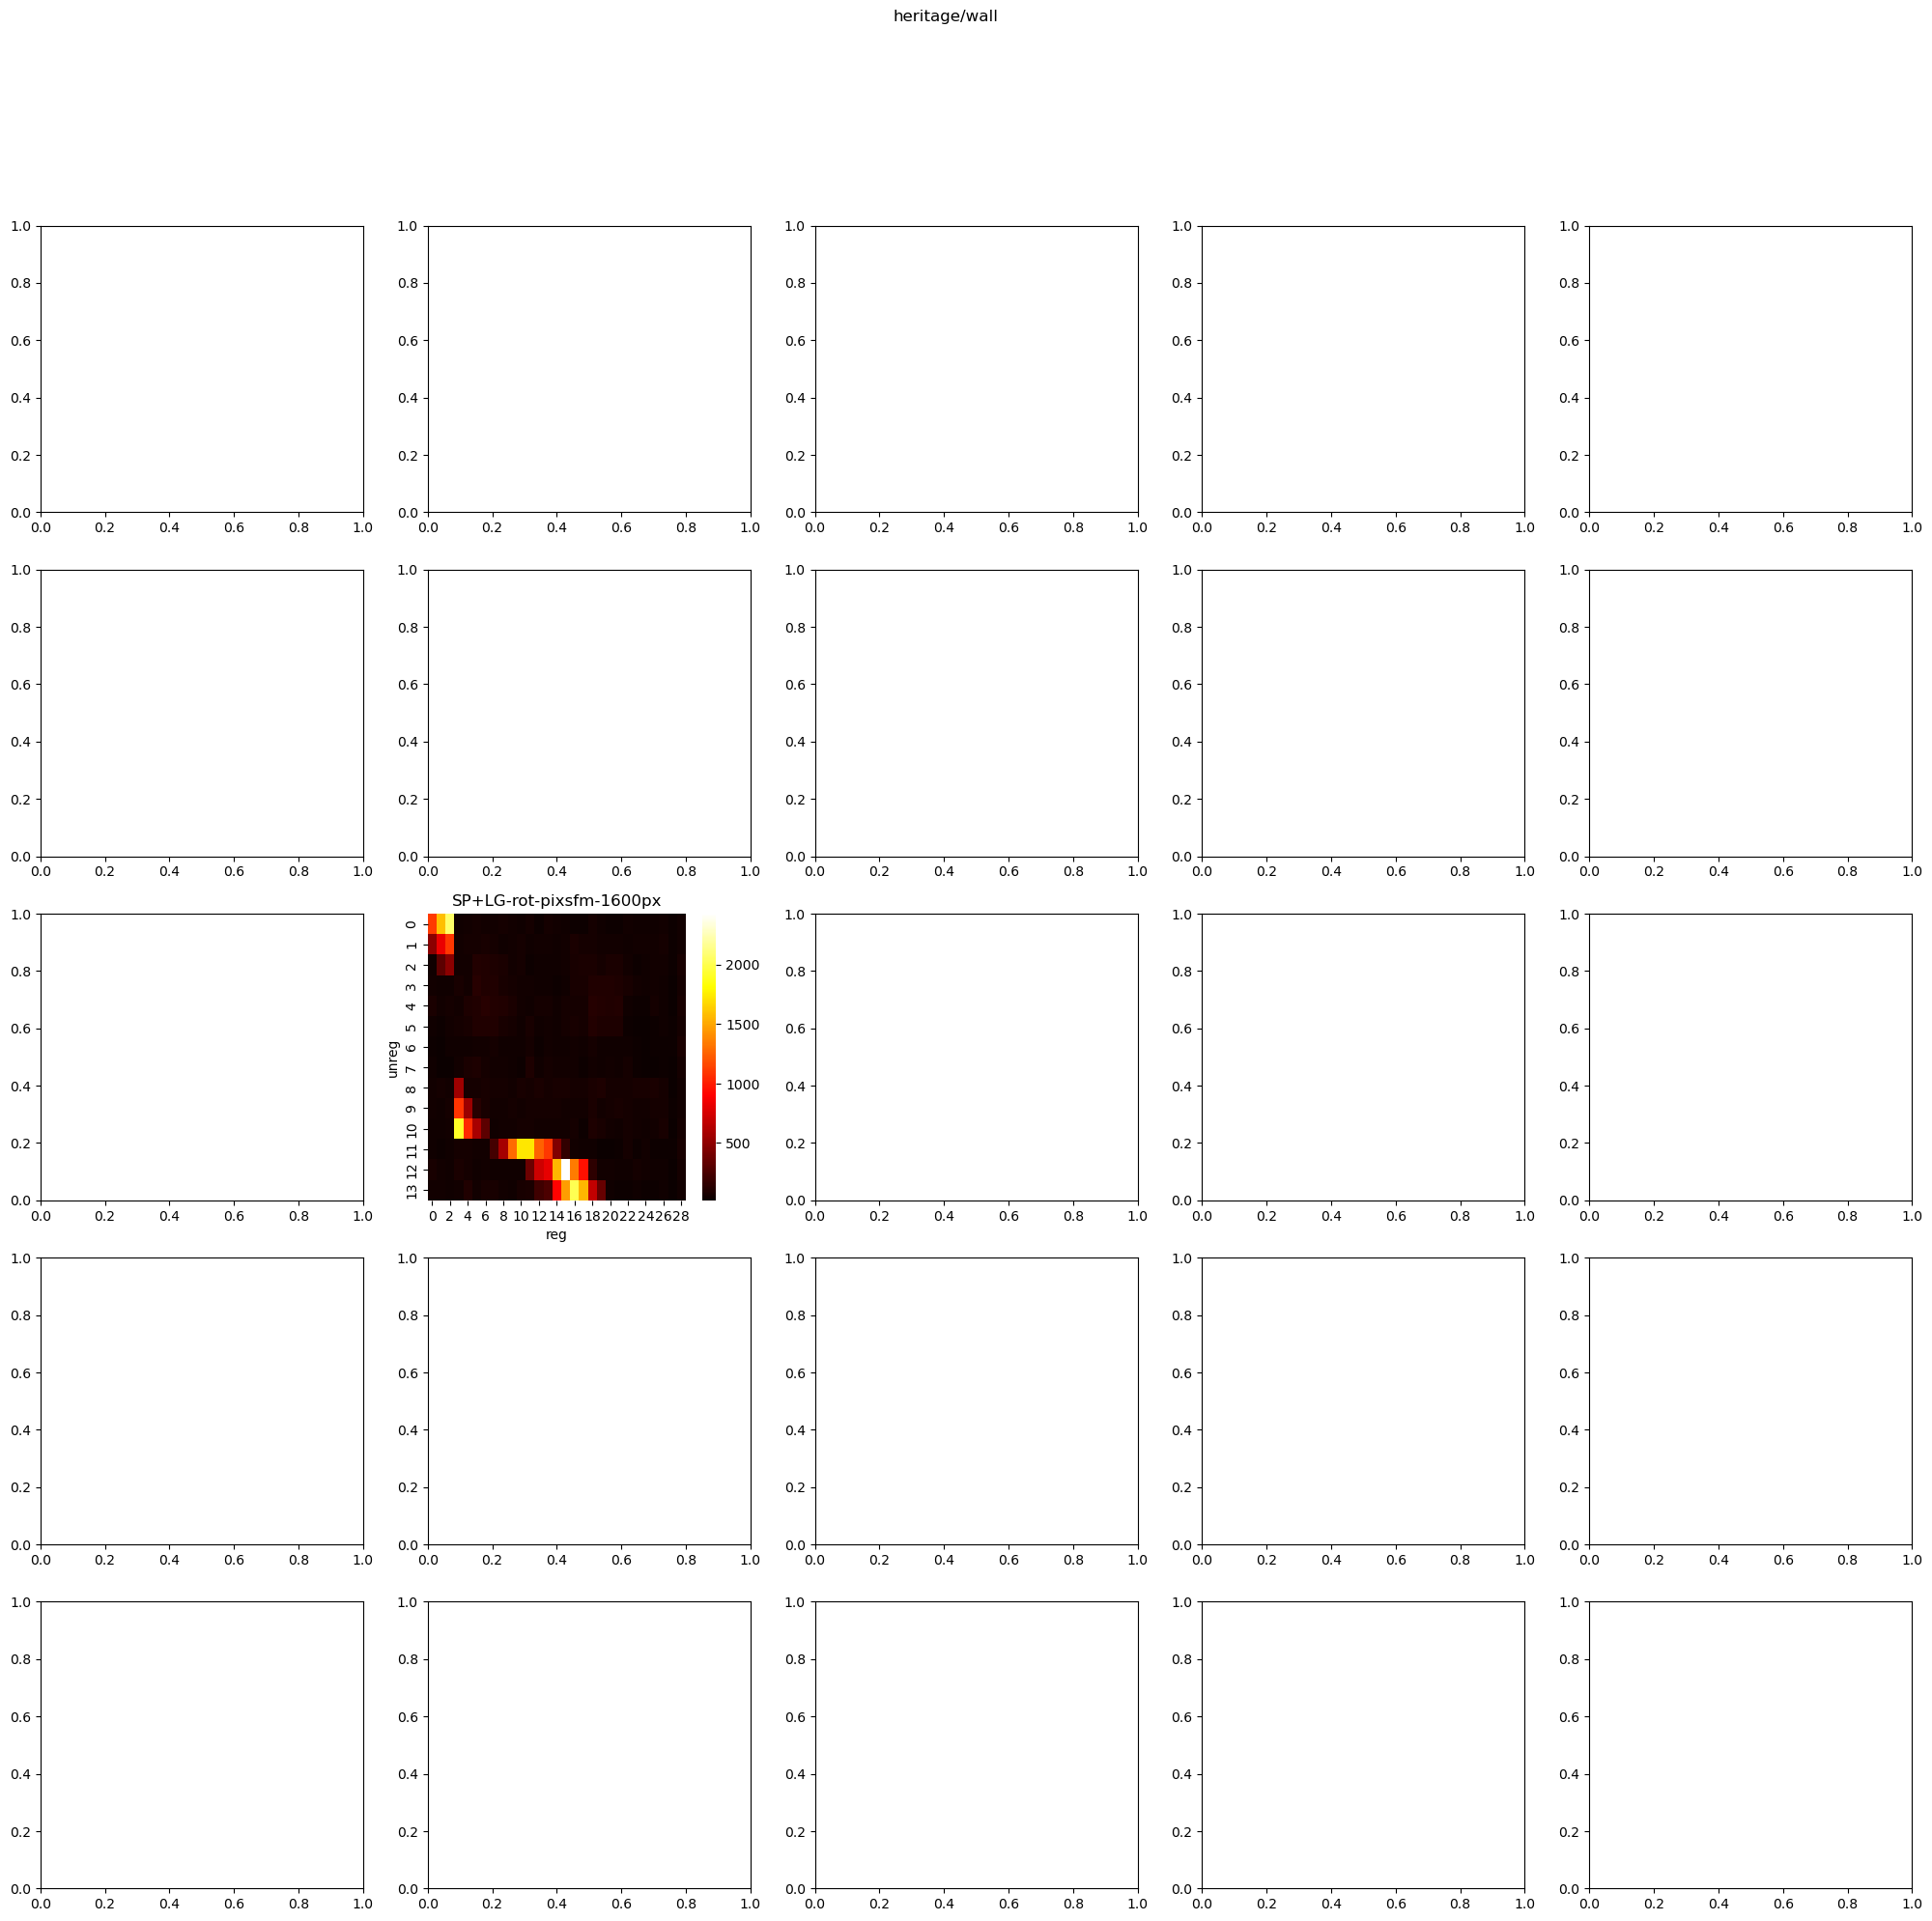

haiper/bike: 100%|██████████| 20/20 [00:00<00:00, 31.71it/s]


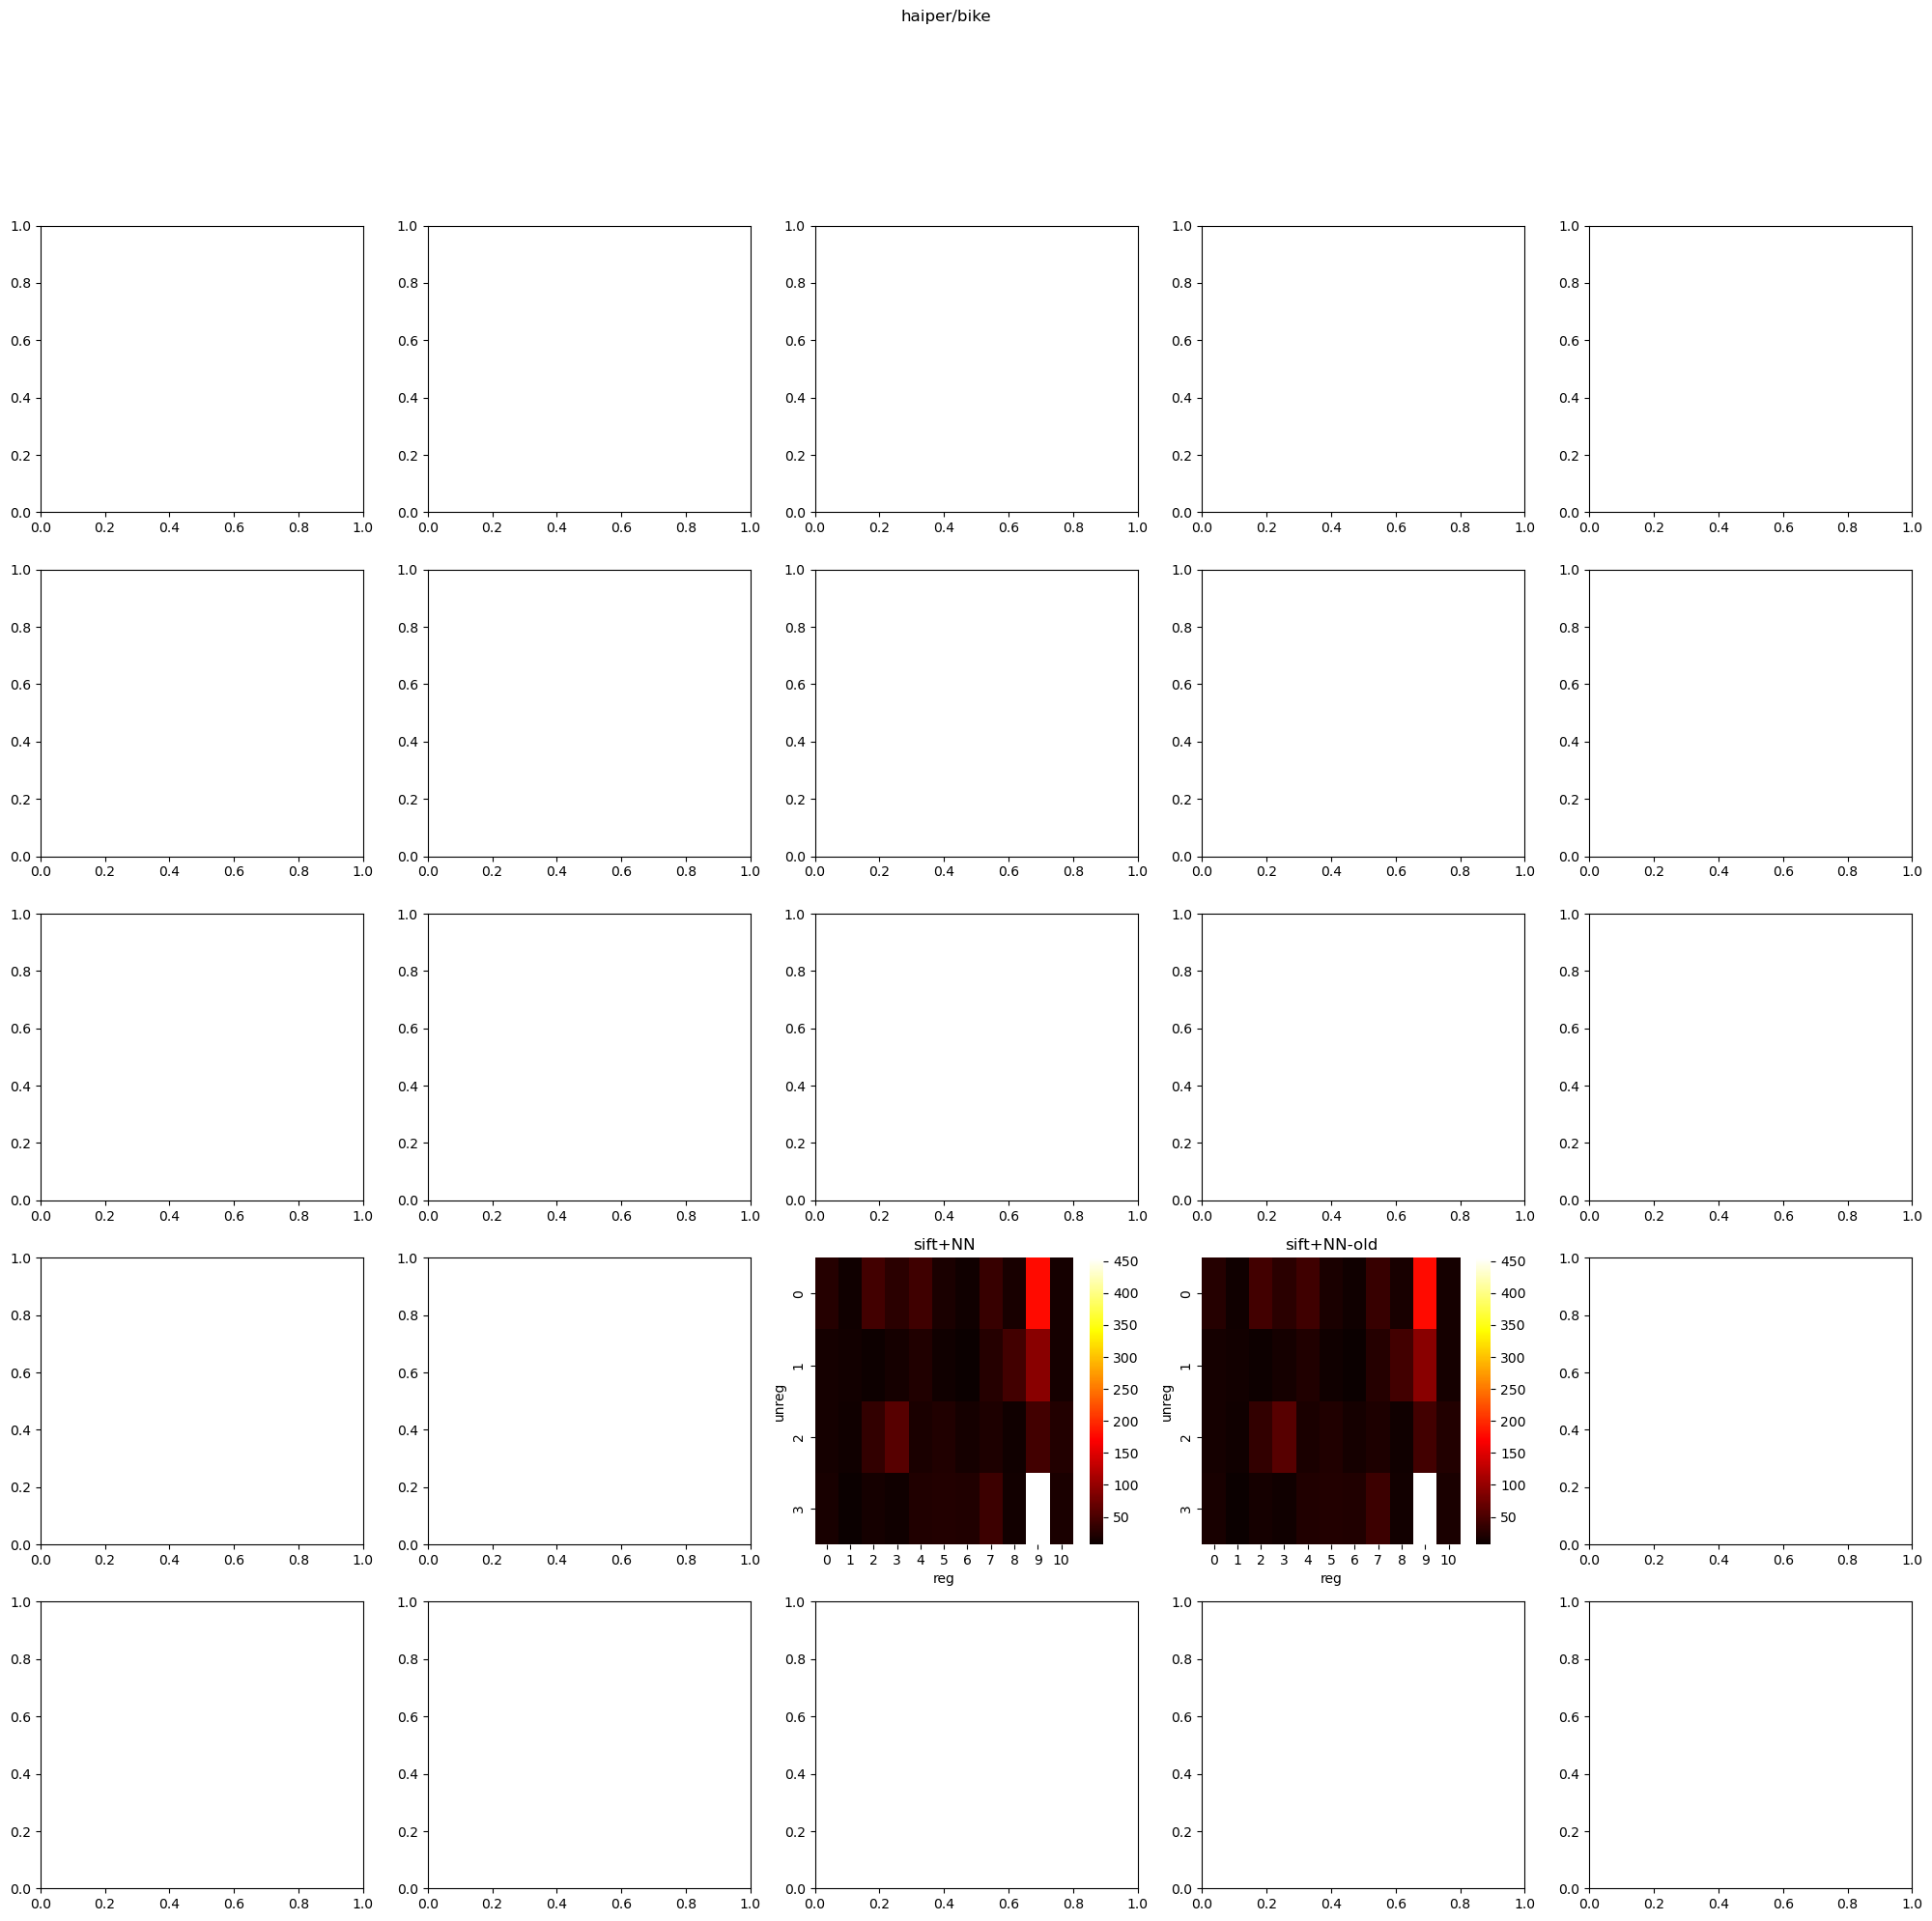

haiper/chairs: 100%|██████████| 20/20 [00:00<00:00, 36.24it/s]


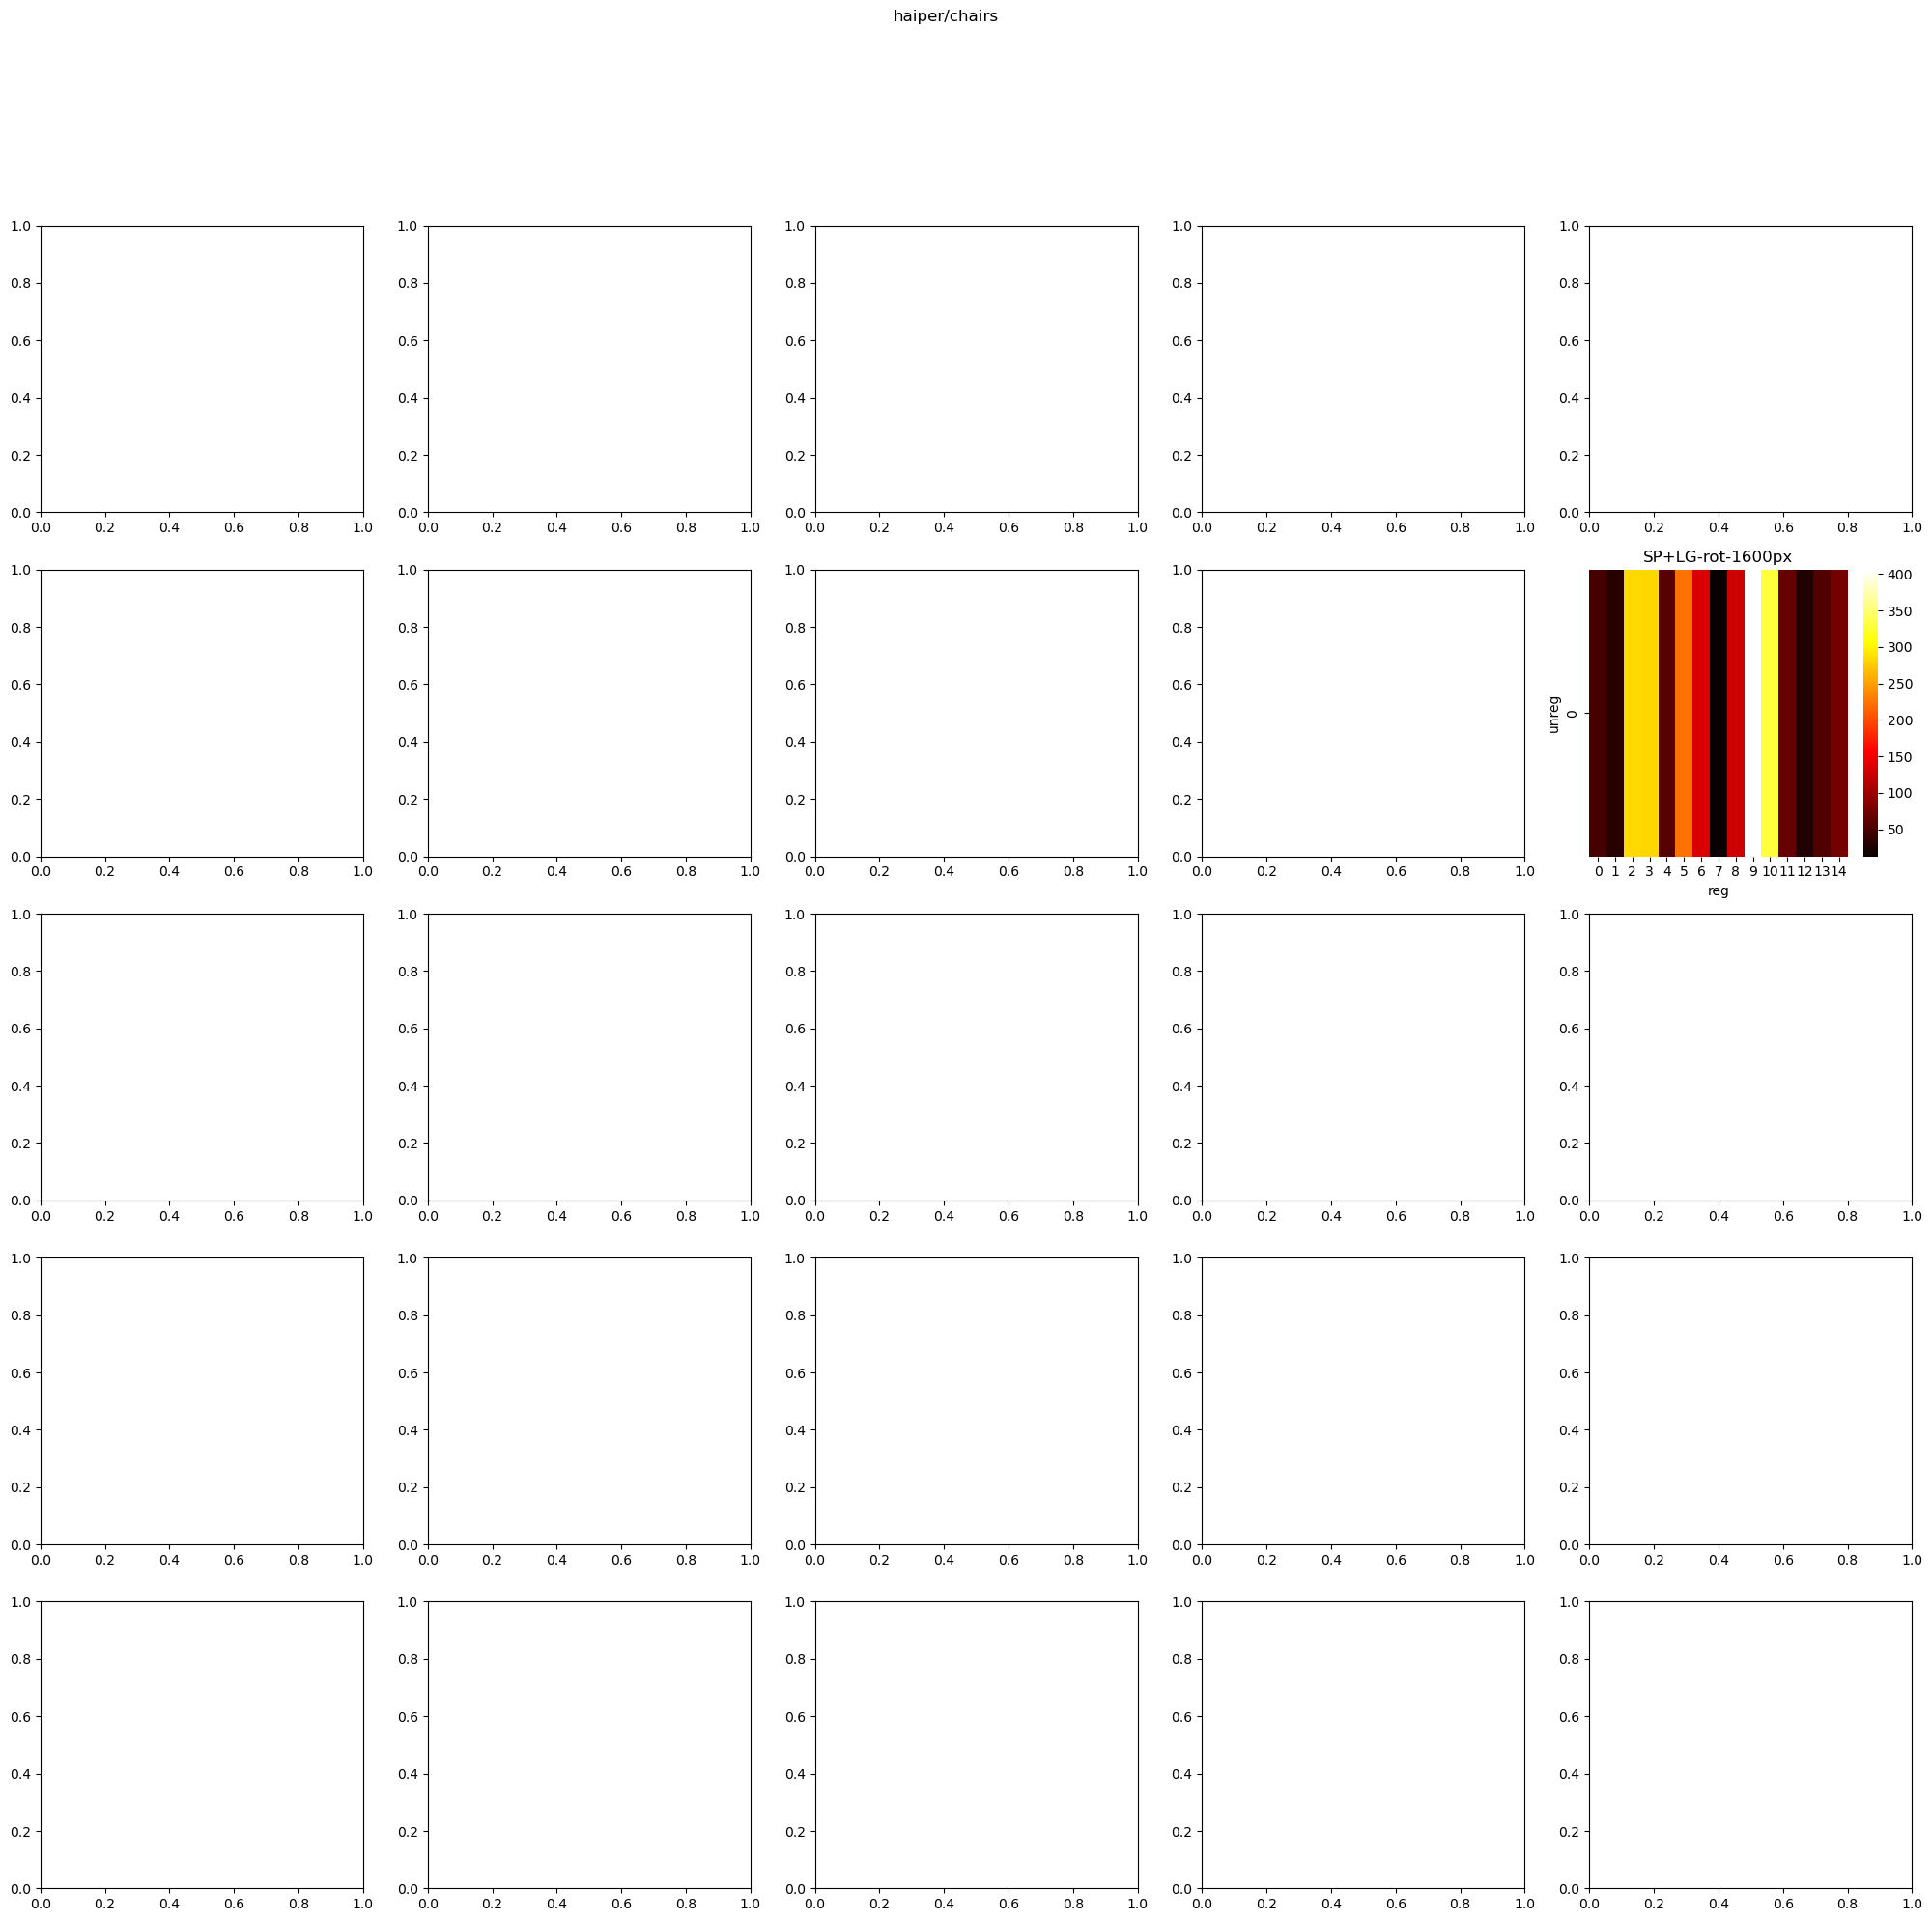

haiper/fountain: 100%|██████████| 20/20 [00:00<00:00, 141.95it/s]


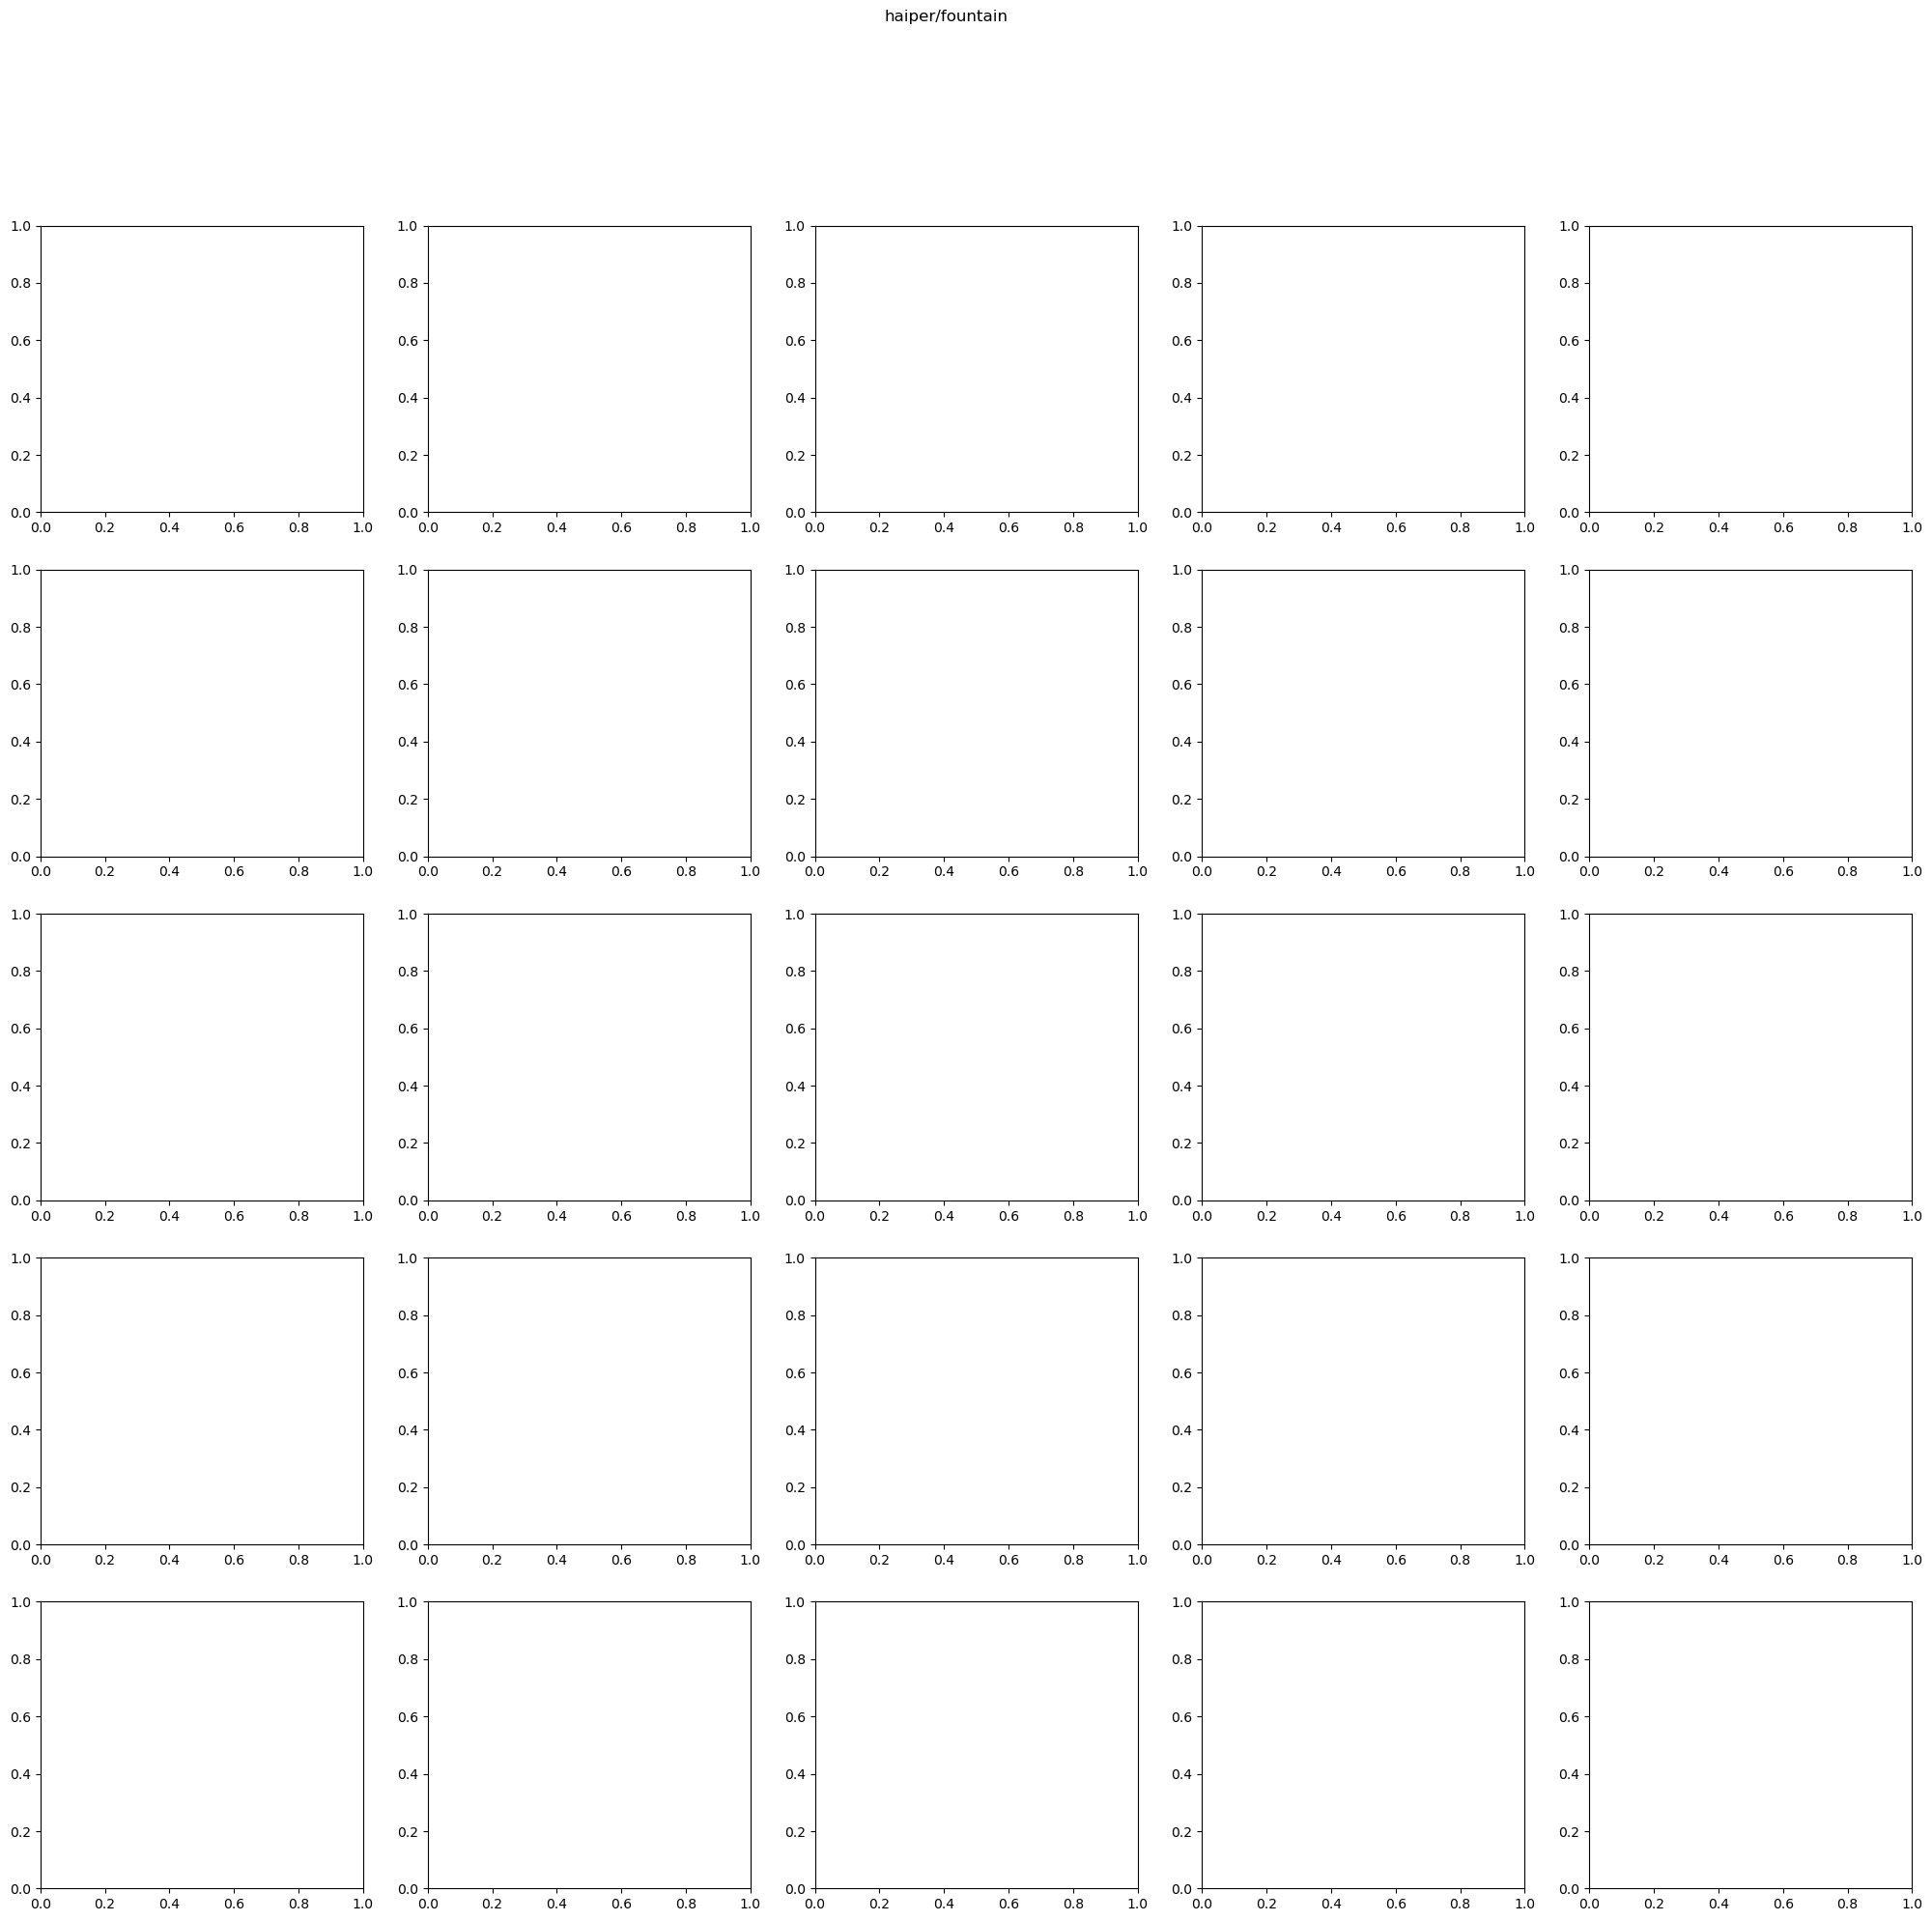

urban/kyiv-puppet-theater: 100%|██████████| 20/20 [00:00<00:00, 31.69it/s]


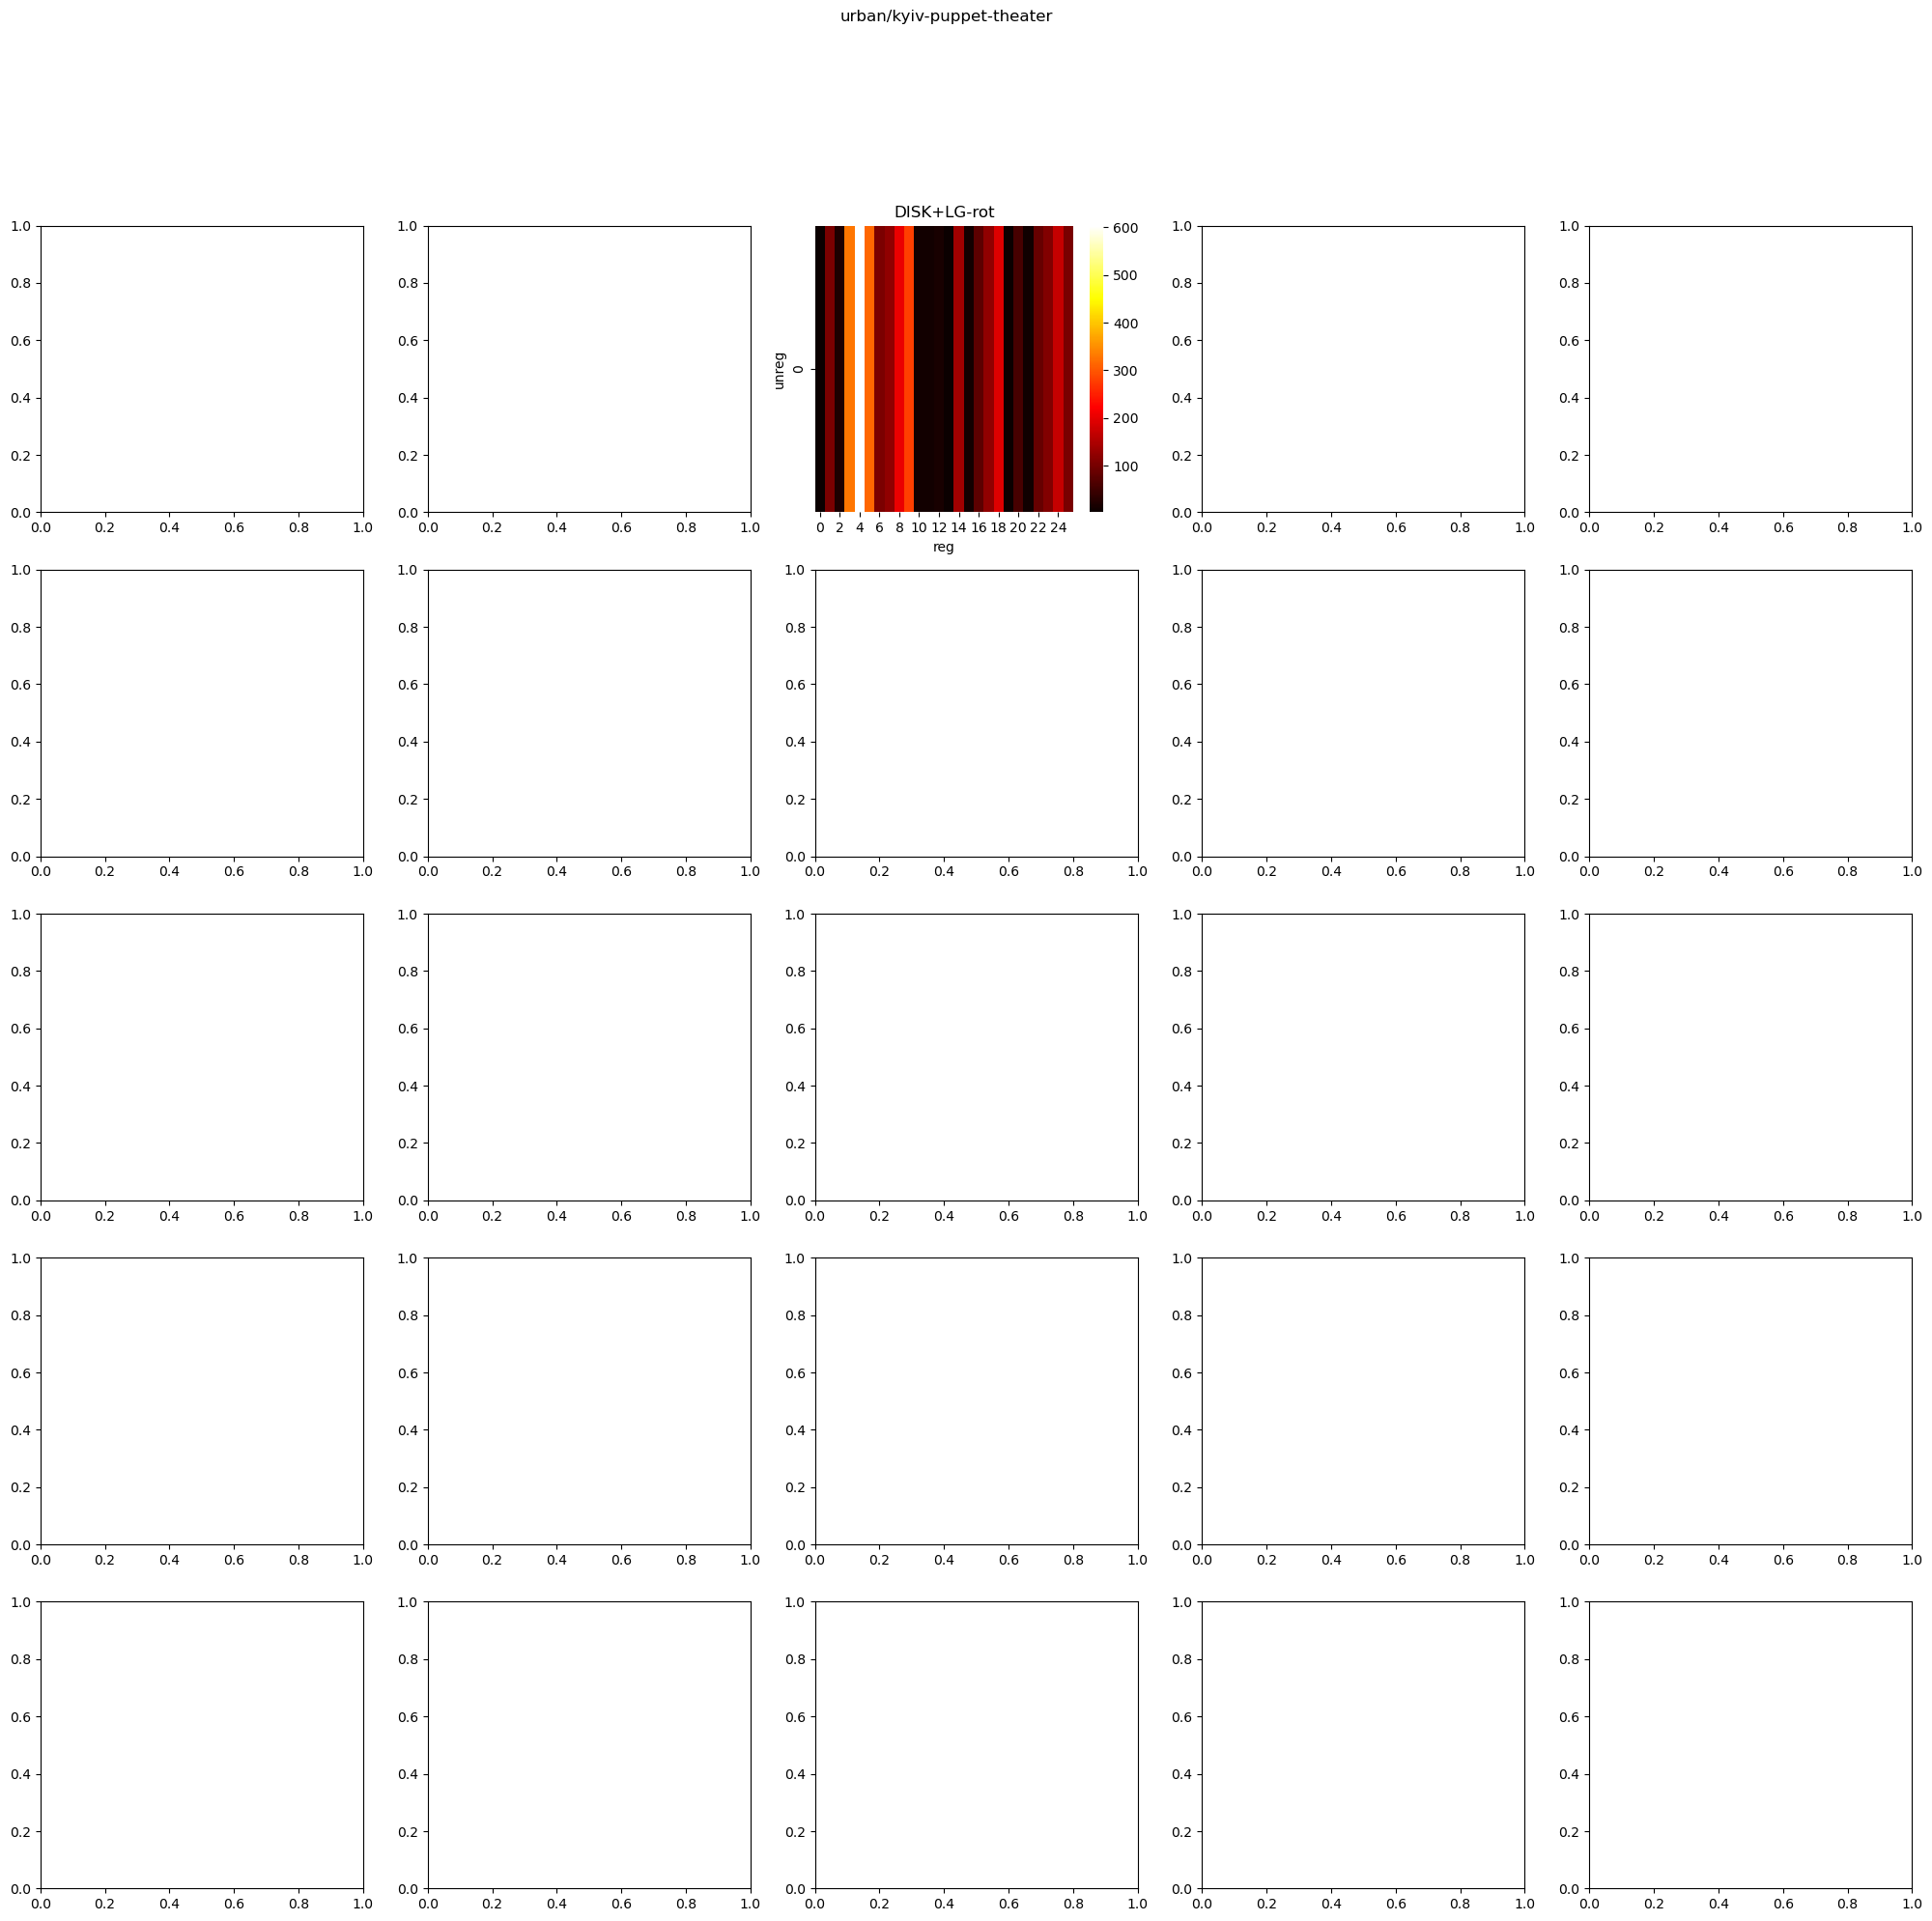

In [ ]:

for i, ds in enumerate(datasets.keys()):
    for j, scene in enumerate(datasets[ds]):
        image_names = metrics[ds][scene]["images"]

        pbar = tqdm(runs, desc=f"{ds}/{scene}")
        
        rows = np.sqrt(len(runs))
        cols = np.ceil(len(runs) / rows)
        fig, ax = plt.subplots(int(rows+1), int(cols), figsize=(5 * cols, 5 * rows))

        for r_idx, r in enumerate(pbar):

            scene_dir = Path(f"{out_dir}/{r}/{ds}/{scene}")

            matches = scene_dir / "matches.h5"

            if not matches.exists():
                continue

            reg_images = metrics[ds][scene][r]["reg_images"]
            unreg_images = [img for img in image_names if img not in reg_images]

            if len(unreg_images) == 0 or len(reg_images) == 0:
                continue


            pairs = sorted(list_h5_names(matches))
            
            match_matrix = -np.ones([len(unreg_images), len(reg_images)])
            for pair in pairs:
                name0, name1 = pair.split("/")
                m, sc = get_matches(matches, name0, name1)

                if name0 in unreg_images and name1 in reg_images:
                    idx0, idx1 = unreg_images.index(name0), reg_images.index(name1)
                    match_matrix[idx0, idx1] = m.shape[0]

                elif name1 in unreg_images and name0 in reg_images:
                    idx0, idx1 = unreg_images.index(name1), reg_images.index(name0)
                    match_matrix[idx0, idx1] = m.shape[0]                

            sns.heatmap(
                match_matrix,
                ax=ax[int(r_idx // cols), int(r_idx % cols)],
                cbar=True,
                cmap="hot",
                mask=(match_matrix < 0),
            )

            ax[int(r_idx // cols), int(r_idx % cols)].set_title(r)
            ax[int(r_idx // cols), int(r_idx % cols)].set_xlabel("reg")
            ax[int(r_idx // cols), int(r_idx % cols)].set_ylabel("unreg")

        plt.suptitle(f"{ds}/{scene}")
        plt.show()
